In [2]:
import math
import numpy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import sys
import joblib
import warnings

In [3]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as Sfs
from sklearn.feature_selection import chi2
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from matplotlib.ticker import PercentFormatter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from dateutil.relativedelta import relativedelta
from imblearn.over_sampling import SMOTE
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from collections import Counter

In [4]:
sns.set()

# Data Import and overview

In [5]:
POPULARITY = "../../data/popularity_v2.csv"
df = pd.read_csv(filepath_or_buffer=POPULARITY, sep=",")
df = df.sort_values(by='timestamp', ascending=True)
df.tail()

,Unnamed: 0,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,topics_ids,topics,sentiment,popularity,followers,following,tweet_count,verified,created_at
1056093,1056093,1477036840318234625,Love the @psychedelic_nft project and what @BA...,2021-12-31 21:59:59+00:00,78500713,0,0,0,0,530,NaN,NaN,Positive,0,530,1248,5767,False,2009-09-30 03:22:06+00:00
1056094,1056094,1477036840213520389,They know all this shit get rocky like Balboa,2021-12-31 21:59:59+00:00,1418931350241959948,3,0,0,0,11673,NaN,NaN,Negative,0,11673,791,5254,False,2021-07-24 13:49:45+00:00
1056095,1056095,1477036840205131786,all these folks getting off their cincinnati t...,2021-12-31 21:59:59+00:00,28413887,74,1,0,4,16524,NaN,NaN,Positive,1,16524,792,74692,False,2009-04-02 20:34:42+00:00
1056097,1056097,1477036839894720523,Check out PaymentMake .com / NR #Domain Auctio...,2021-12-31 21:59:59+00:00,865260471406014466,0,0,0,0,280,45.0,Brand Vertical,Neutral,0,280,423,7413,False,2017-05-18 17:39:06+00:00
1056261,1056261,1477036842704797697,It looks Amazing!!! ヽ(´∀`。)ﾉ To see this on th...,2021-12-31 21:59:59+00:00,1364878549937651714,1,0,0,1,59,119.0,Holiday,Positive,0,59,183,3252,False,2021-02-25 10:03:18+00:00


In [6]:
df.head(10)

,Unnamed: 0,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,topics_ids,topics,sentiment,popularity,followers,following,tweet_count,verified,created_at
0,0,1212176606699180032,IM READY FOR BTS,2020-01-01 00:59:58,1078318888851513347,0,0,0,0,100,NaN,NaN,Positive,0,100,390,3961,False,2018-12-27 15:57:12
1044,1044,1212176605629632513,2 people followed me and 4 people unfollowed m...,2020-01-01 00:59:58,255042521,0,0,0,0,257,NaN,NaN,Neutral,0,257,1028,4807,False,2011-02-20 15:06:34
1042,1042,1212176605650542592,The way she ate every single role un these pho...,2020-01-01 00:59:58,288954365,1,1,0,0,575,10.0,Person,Neutral,1,575,1316,69233,False,2011-04-27 19:05:46+00:00
1041,1041,1212176605684097026,Por favor y reina de no hacer playback https:/...,2020-01-01 00:59:58,827231822,1,0,1,0,1425,NaN,NaN,Positive,1,1425,515,307238,False,2012-09-16 14:54:00
1040,1040,1212176605742809088,I always find myself iterating upon “that’s no...,2020-01-01 00:59:58,1891705003,1,0,0,0,729,NaN,NaN,Neutral,0,729,231,12946,False,2013-09-21 22:25:37
1039,1039,1212176605818347521,Check this. Good news. Germany shuts Philipp...,2020-01-01 00:59:58,1327699430,0,0,0,0,153,NaN,NaN,Positive,0,153,515,12166,False,2013-04-04 19:54:12
1038,1038,1212176605835091968,This whole thread = mind blown https://t.co/Es...,2020-01-01 00:59:58,344763445,1,0,0,0,1571,NaN,NaN,Neutral,0,1571,918,5880,False,2011-07-29 15:08:36
1037,1037,1212176605839101952,Farewell and thank you to the most awesome and...,2020-01-01 00:59:58,17767620,2,0,0,0,3811,NaN,NaN,Positive,0,3811,2148,11725,False,2008-12-01 01:10:00
1036,1036,1212176605872828418,Share what brings you joy for a chance to win ...,2020-01-01 00:59:58,377075281,0,0,0,0,1060,65.0,Interests and Hobbies Vertical,Positive,0,1060,3713,42748,False,2011-09-20 23:59:07
125,125,1212176606900436997,Sometimes you have to stop talking. They’re no...,2020-01-01 00:59:58,984551132000342018,1,0,0,0,1320,NaN,NaN,Positive,0,1320,1378,3059,False,2018-04-12 21:57:36


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1056262 entries, 0 to 1056261
Data columns (total 19 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Unnamed: 0     1056262 non-null  int64  
 1   tweet_id       1056262 non-null  int64  
 2   text           1056262 non-null  object 
 3   timestamp      1056262 non-null  object 
 4   user_id        1056262 non-null  int64  
 5   like_count     1056262 non-null  int64  
 6   retweet_count  1056262 non-null  int64  
 7   quote_count    1056262 non-null  int64  
 8   reply_count    1056262 non-null  int64  
 9   reach          1056262 non-null  int64  
 10  topics_ids     361429 non-null   float64
 11  topics         361429 non-null   object 
 12  sentiment      1056262 non-null  object 
 13  popularity     1056262 non-null  int64  
 14  followers      1056262 non-null  int64  
 15  following      1056262 non-null  int64  
 16  tweet_count    1056262 non-null  int64  
 17  verified

### Drop duplicates

In [8]:
duplicated = df[df.duplicated(subset = df.columns[1:])]
duplicated

,Unnamed: 0,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,topics_ids,topics,sentiment,popularity,followers,following,tweet_count,verified,created_at


### Remove Nan values

In [9]:
df.isna().sum()

Unnamed: 0            0
tweet_id              0
text                  0
timestamp             0
user_id               0
like_count            0
retweet_count         0
quote_count           0
reply_count           0
reach                 0
topics_ids       694833
topics           694833
sentiment             0
popularity            0
followers             0
following             0
tweet_count           0
verified              0
created_at            0
dtype: int64

In [10]:
df['created_at'].isna().sum()
df = df[df['created_at'].notna()]

## Data Wrangling

Nesta etapa as seguintes tarefas vão ser realizadas:
- Renomear algumas colunas para melhor compreensão dos dados
- Converter nomenclaturas/abreviações para melhor processamento de dados
- Criar novas colunas de categorias para agrupar os diferentes individuos, segundo, fatores de risco

### Variables categorization

In [11]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

#### Categorize by year, month, week days and phases of the day

In [12]:
def get_day_phase(hour):
    if 0 <= hour < 7:
        return "Dawn"
    elif 7 <= hour < 13:
        return "Morning"
    elif 13 <= hour < 16:
        return "Afternoon"
    elif 16 <= hour < 20:
        return "Evening"
    elif 20 <= hour < 24:
        return "Night"

In [13]:
df['year'] = df['timestamp'].apply(lambda x: x.year)
df['month'] = df['timestamp'].apply(lambda x: x.strftime('%B'))
df['day_of_week'] = df['timestamp'].apply(lambda x: x.strftime('%A'))
df['day_phase'] = df['timestamp'].apply(lambda x: get_day_phase(int(x.hour)))
df['week_idx'] = df['timestamp'].apply(lambda x: '%s-%s' % (x.year, '{:02d}'.format(x.isocalendar()[1])))
df

,Unnamed: 0,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,...,followers,following,tweet_count,verified,created_at,year,month,day_of_week,day_phase,week_idx
0,0,1212176606699180032,IM READY FOR BTS,2020-01-01 00:59:58,1078318888851513347,0,0,0,0,100,...,100,390,3961,False,2018-12-27 15:57:12,2020,January,Wednesday,Dawn,2020-01
1044,1044,1212176605629632513,2 people followed me and 4 people unfollowed m...,2020-01-01 00:59:58,255042521,0,0,0,0,257,...,257,1028,4807,False,2011-02-20 15:06:34,2020,January,Wednesday,Dawn,2020-01
1042,1042,1212176605650542592,The way she ate every single role un these pho...,2020-01-01 00:59:58,288954365,1,1,0,0,575,...,575,1316,69233,False,2011-04-27 19:05:46+00:00,2020,January,Wednesday,Dawn,2020-01
1041,1041,1212176605684097026,Por favor y reina de no hacer playback https:/...,2020-01-01 00:59:58,827231822,1,0,1,0,1425,...,1425,515,307238,False,2012-09-16 14:54:00,2020,January,Wednesday,Dawn,2020-01
1040,1040,1212176605742809088,I always find myself iterating upon “that’s no...,2020-01-01 00:59:58,1891705003,1,0,0,0,729,...,729,231,12946,False,2013-09-21 22:25:37,2020,January,Wednesday,Dawn,2020-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056093,1056093,1477036840318234625,Love the @psychedelic_nft project and what @BA...,2021-12-31 21:59:59+00:00,78500713,0,0,0,0,530,...,530,1248,5767,False,2009-09-30 03:22:06+00:00,2021,December,Friday,Night,2021-52
1056094,1056094,1477036840213520389,They know all this shit get rocky like Balboa,2021-12-31 21:59:59+00:00,1418931350241959948,3,0,0,0,11673,...,11673,791,5254,False,2021-07-24 13:49:45+00:00,2021,December,Friday,Night,2021-52
1056095,1056095,1477036840205131786,all these folks getting off their cincinnati t...,2021-12-31 21:59:59+00:00,28413887,74,1,0,4,16524,...,16524,792,74692,False,2009-04-02 20:34:42+00:00,2021,December,Friday,Night,2021-52
1056097,1056097,1477036839894720523,Check out PaymentMake .com / NR #Domain Auctio...,2021-12-31 21:59:59+00:00,865260471406014466,0,0,0,0,280,...,280,423,7413,False,2017-05-18 17:39:06+00:00,2021,December,Friday,Night,2021-52


In [14]:

enc = LabelEncoder()

# Day phase: Dawn -> 1 | Morning -> 3 | Afternoon -> 0 | Evening -> 2 | Night -> 4
enc.fit(df['day_phase'])
df['day_phase_enc'] = enc.transform(df['day_phase'])

# Days of the week:
#   Monday -> 1 | Tuesday -> 5 | Wednesday -> 6
#   Thursday -> 4 | Friday -> 0 | Saturday -> 2 | Sunday -> 3
enc.fit(df['day_of_week'])
df['day_of_week_enc'] = enc.transform(df['day_of_week'])

# Months
#   January -> 4 | February -> 3 | March -> 7 | April -> 0
#   May -> 8 | June -> 6 | July -> 5 | August -> 1
#   September -> 11 | October -> 10 | November -> 9 | December -> 2
enc.fit(df['month'])
df['month_enc'] = enc.transform(df['month'])

# Years
#   2020 -> 0 | 2021 -> 1
enc.fit(df['year'])
df['year_enc'] = enc.transform(df['year'])

# Sentiment
#  Negative -> 0 | Neutral -> 1 | Positive -> 2
enc.fit(df['sentiment'])
df['sentiment_enc'] = enc.transform(df['sentiment'])

# Verified
#  False -> 0 | True -> 1
enc.fit(df['verified'])
df['verified_enc'] = enc.transform(df['verified'])

df.head(5)

,Unnamed: 0,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,...,month,day_of_week,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc
0,0,1212176606699180032,IM READY FOR BTS,2020-01-01 00:59:58,1078318888851513347,0,0,0,0,100,...,January,Wednesday,Dawn,2020-01,1,6,4,0,2,0
1044,1044,1212176605629632513,2 people followed me and 4 people unfollowed m...,2020-01-01 00:59:58,255042521,0,0,0,0,257,...,January,Wednesday,Dawn,2020-01,1,6,4,0,1,0
1042,1042,1212176605650542592,The way she ate every single role un these pho...,2020-01-01 00:59:58,288954365,1,1,0,0,575,...,January,Wednesday,Dawn,2020-01,1,6,4,0,1,0
1041,1041,1212176605684097026,Por favor y reina de no hacer playback https:/...,2020-01-01 00:59:58,827231822,1,0,1,0,1425,...,January,Wednesday,Dawn,2020-01,1,6,4,0,2,0
1040,1040,1212176605742809088,I always find myself iterating upon “that’s no...,2020-01-01 00:59:58,1891705003,1,0,0,0,729,...,January,Wednesday,Dawn,2020-01,1,6,4,0,1,0


In [15]:
df['created_at'] = pd.to_datetime(df['created_at'], utc=True).dt.strftime("%Y-%m-%d")
df['created_at'] = pd.to_datetime(df['created_at'])
df['seniority'] = df['created_at'].apply(lambda x: relativedelta(datetime.datetime.now(), x).years)
df.head(5)

,Unnamed: 0,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,...,day_of_week,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc,seniority
0,0,1212176606699180032,IM READY FOR BTS,2020-01-01 00:59:58,1078318888851513347,0,0,0,0,100,...,Wednesday,Dawn,2020-01,1,6,4,0,2,0,3
1044,1044,1212176605629632513,2 people followed me and 4 people unfollowed m...,2020-01-01 00:59:58,255042521,0,0,0,0,257,...,Wednesday,Dawn,2020-01,1,6,4,0,1,0,11
1042,1042,1212176605650542592,The way she ate every single role un these pho...,2020-01-01 00:59:58,288954365,1,1,0,0,575,...,Wednesday,Dawn,2020-01,1,6,4,0,1,0,10
1041,1041,1212176605684097026,Por favor y reina de no hacer playback https:/...,2020-01-01 00:59:58,827231822,1,0,1,0,1425,...,Wednesday,Dawn,2020-01,1,6,4,0,2,0,9
1040,1040,1212176605742809088,I always find myself iterating upon “that’s no...,2020-01-01 00:59:58,1891705003,1,0,0,0,729,...,Wednesday,Dawn,2020-01,1,6,4,0,1,0,8


In [16]:
df['topics_ids'].fillna(value=0, inplace=True)
df['topics_ids'] = df['topics_ids'].apply(lambda x: int(x))
df['topics'].fillna(value="", inplace=True)
df.head(5)

,Unnamed: 0,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,...,day_of_week,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc,seniority
0,0,1212176606699180032,IM READY FOR BTS,2020-01-01 00:59:58,1078318888851513347,0,0,0,0,100,...,Wednesday,Dawn,2020-01,1,6,4,0,2,0,3
1044,1044,1212176605629632513,2 people followed me and 4 people unfollowed m...,2020-01-01 00:59:58,255042521,0,0,0,0,257,...,Wednesday,Dawn,2020-01,1,6,4,0,1,0,11
1042,1042,1212176605650542592,The way she ate every single role un these pho...,2020-01-01 00:59:58,288954365,1,1,0,0,575,...,Wednesday,Dawn,2020-01,1,6,4,0,1,0,10
1041,1041,1212176605684097026,Por favor y reina de no hacer playback https:/...,2020-01-01 00:59:58,827231822,1,0,1,0,1425,...,Wednesday,Dawn,2020-01,1,6,4,0,2,0,9
1040,1040,1212176605742809088,I always find myself iterating upon “that’s no...,2020-01-01 00:59:58,1891705003,1,0,0,0,729,...,Wednesday,Dawn,2020-01,1,6,4,0,1,0,8


In [17]:
vars = ['like_count', 'retweet_count', 'quote_count', 'reach', 'topics_ids', 'sentiment_enc', 'day_phase_enc', 'day_of_week_enc', 'month_enc', 'popularity', 'followers', 'following', 'tweet_count', 'verified_enc', 'seniority']
tweet_vars = ['like_count', 'retweet_count', 'quote_count', 'reach', 'sentiment_enc', 'day_phase_enc', 'day_of_week_enc', 'month_enc']
users_vars = ['followers', 'following', 'tweet_count', 'verified_enc', 'seniority']
num_vars = ['like_count', 'retweet_count', 'quote_count', 'reach', 'followers', 'following', 'tweet_count', 'seniority']
cat_vars = ['sentiment_enc', 'verified_enc', 'day_of_week_enc', 'day_phase_enc', 'month_enc']

## Spliting the data by year

In [18]:
df_2020 = df[df['year'] == 2020]
df_2021 = df[df['year'] == 2021]

In [19]:
df_2020.shape

(528818, 31)

In [20]:
df_2021.shape

(527444, 31)

# EDA

- Understanding the behavior of tweets popularity througth different time periods
- Data visualization
- Outliers

## Tweets performance in 2020

In [21]:
tweet_analysis = pd.DataFrame(data=df_2020[['day_phase', 'day_of_week', 'month', 'retweet_count', 'quote_count', 'like_count', 'topics', 'sentiment']])

In [22]:
tweet_analysis1 = tweet_analysis.groupby(['day_phase']).agg(
                                                            day_phase_count=pd.NamedAgg(column="day_phase", aggfunc="count"),
                                                            retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
                                                            likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['day_phase']).reset_index()
tweet_analysis1

,day_phase,day_phase_count,retweet_count,likes_count
0,Afternoon,106089,2.465421,10.269708
1,Dawn,105630,3.079703,17.981293
2,Evening,105846,2.119334,11.010241
3,Morning,105674,2.792238,11.298721
4,Night,105579,3.989979,19.417905


### Retweet count per phase of the day chart

In [23]:
def analysis_chart(analysis, col_name, x_bar, y_bar, fig_size_width):
    ax1 = sns.set_style(style='white', rc=None)
    fig, ax1 = plt.subplots(figsize=(fig_size_width, 10))
    sns.barplot(data=analysis, x=x_bar, y=y_bar, ax=ax1, color='#B33951')
    ax2 = ax1.twinx()
    sns.lineplot(data=analysis[col_name], marker='o', sort=False, ax=ax2)

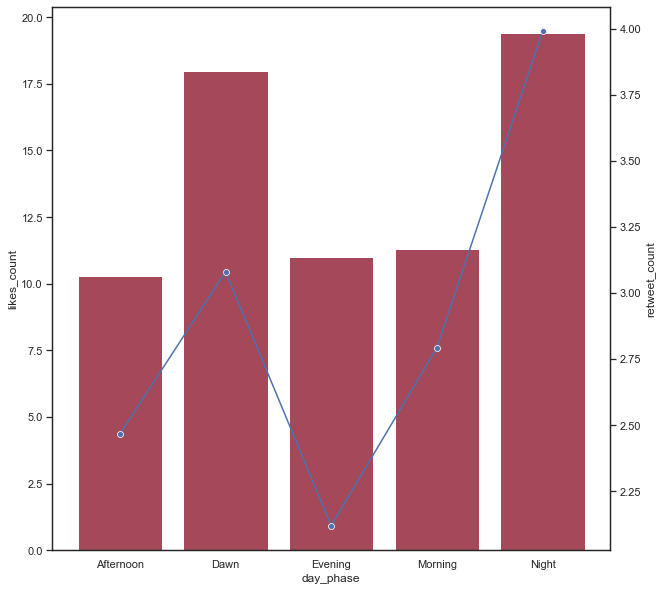

In [24]:
analysis_chart(tweet_analysis1, 'retweet_count', 'day_phase', 'likes_count', 10)

### Retweet count per day of the week

In [25]:
tweet_analysis2 = tweet_analysis.groupby(['day_of_week']).agg(
    day_of_week_count=pd.NamedAgg(column="day_of_week", aggfunc="count"),
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['day_of_week']).reset_index()
tweet_analysis2

,day_of_week,day_of_week_count,retweet_count,likes_count
0,Friday,75208,2.600601,13.232263
1,Monday,75151,1.972495,11.414925
2,Saturday,75081,2.471464,10.827839
3,Sunday,74982,1.733229,9.707770
4,Thursday,76570,5.222019,21.772313
5,Tuesday,75200,2.613085,13.822566
6,Wednesday,76626,3.547295,16.938246


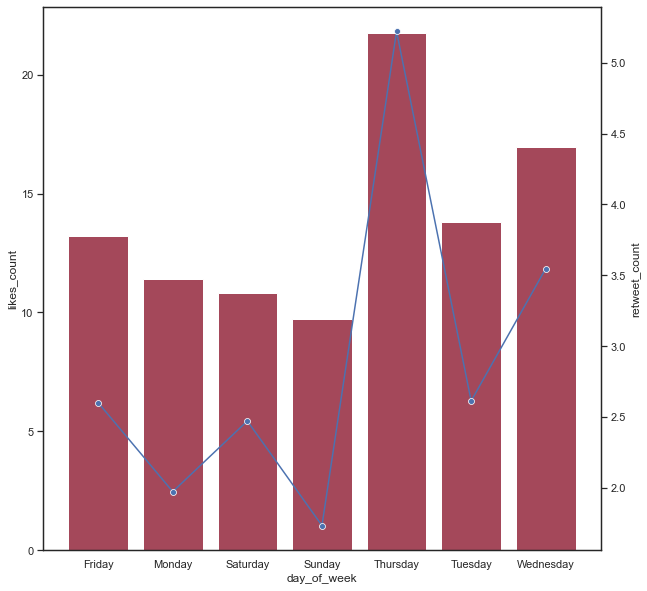

In [26]:
analysis_chart(tweet_analysis2, 'retweet_count', 'day_of_week', 'likes_count', 10)

### Retweet count per month

In [27]:
tweet_analysis3 = tweet_analysis.groupby(['month']).agg(
    month_count=pd.NamedAgg(column="month", aggfunc="count"),
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['month']).reset_index()
tweet_analysis3

,month,month_count,retweet_count,likes_count
0,April,43658,1.627399,8.042398
1,August,44703,6.839094,27.293247
2,December,43860,1.414797,10.600091
3,February,42303,3.389192,13.887478
4,January,45245,2.002475,9.444823
5,July,44815,6.265848,31.026375
6,June,43426,1.895408,9.996891
7,March,45206,2.113436,8.865881
8,May,45020,2.570791,13.234829
9,November,42847,1.632250,10.858240


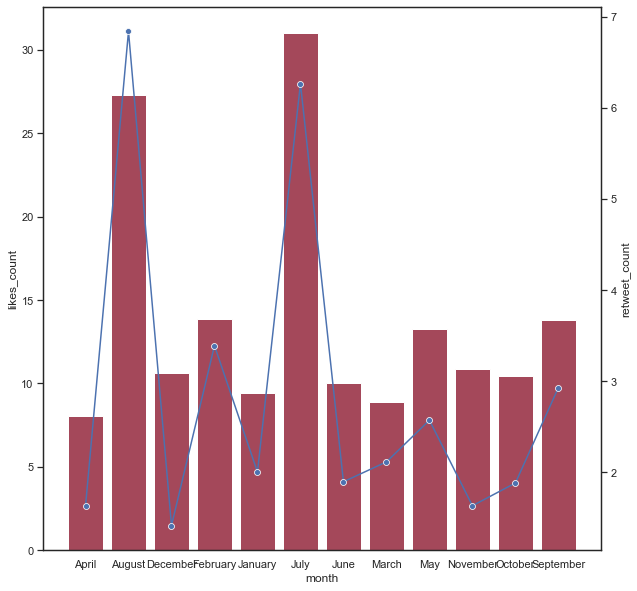

In [28]:
analysis_chart(tweet_analysis3, 'retweet_count', 'month', 'likes_count', 10)

### Tweets performance by sentiment

In [29]:
tweet_analysis4 = tweet_analysis.groupby(['sentiment']).agg(
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['retweet_count'], ascending=False).reset_index()
tweet_analysis4

,sentiment,retweet_count,likes_count
0,Positive,3.039404,15.822797
1,Neutral,3.027576,13.405013
2,Negative,2.415071,11.426832


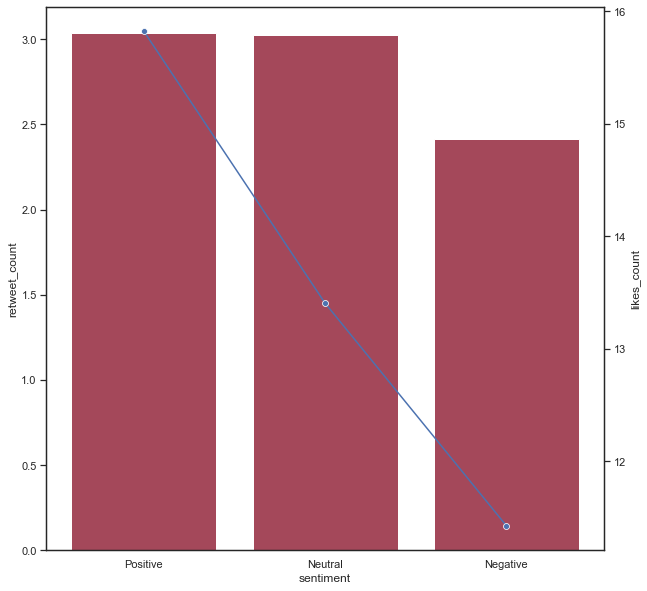

In [151]:
analysis_chart(tweet_analysis4, 'likes_count', 'sentiment', 'retweet_count', 10)

### Tweets performance by topics

In [33]:
topic_analysis = tweet_analysis[tweet_analysis['topics'] != '']

In [34]:
def clean_topics(topic):
    if 'Brand' in topic:
        return 'Brand'
    elif 'Sport' in topic:
        return 'Sport'
    elif 'Hobbies' in topic:
        return 'Interest and Hobbies'
    elif 'Video Game' in topic:
        return 'Video Game'
    else:
        return topic

In [35]:
topic_analysis['topics_cleaned'] = topic_analysis['topics'].apply(lambda topic: clean_topics(topic))
topic_analysis

/Users/migueloliveira/PycharmProjects/SocialInsight/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,day_phase,day_of_week,month,retweet_count,quote_count,like_count,topics,sentiment,topics_cleaned
1042,Dawn,Wednesday,January,1,0,1,Person,Neutral,Person
1036,Dawn,Wednesday,January,0,0,0,Interests and Hobbies Vertical,Positive,Interest and Hobbies
62,Dawn,Wednesday,January,0,0,1,Political Body,Positive,Political Body
61,Dawn,Wednesday,January,0,0,0,Person,Negative,Person
1035,Dawn,Wednesday,January,2,0,6,Person,Positive,Person
...,...,...,...,...,...,...,...,...,...
367294,Night,Thursday,December,1,0,32,Person,Positive,Person
367286,Night,Thursday,December,2,0,13,Esports Team,Negative,Esports Team
612108,Night,Thursday,December,0,0,5,Holiday,Neutral,Holiday
612126,Night,Thursday,December,0,0,0,Person,Neutral,Person


In [36]:
topic_analysis0 = topic_analysis.groupby(['day_phase']).agg(
                                                            day_phase_count=pd.NamedAgg(column="day_phase", aggfunc="count"),
                                                            retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
                                                            likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['day_phase']).reset_index()
topic_analysis0

,day_phase,day_phase_count,retweet_count,likes_count
0,Afternoon,37335,3.897951,15.556261
1,Dawn,37533,5.824608,34.616657
2,Evening,37946,3.250119,16.800084
3,Morning,34220,5.210900,21.023963
4,Night,37709,8.403829,36.330849


In [155]:
topic_analysis['topics_cleaned'].value_counts(normalize=True)

Person                       0.250570
Interest and Hobbies         0.233340
Brand                        0.175368
TV Shows                     0.094504
Ongoing News Story           0.089394
Sport                        0.033105
Video Game                   0.027373
Entities [Entity Service]    0.024190
Holiday                      0.019838
Multimedia Franchise         0.011730
Music Genre                  0.010728
Political Body               0.009326
Fan Community                0.004650
Award Show                   0.003843
Movie                        0.003827
Musician                     0.002425
Book Genre                   0.002079
Movie Genre                  0.001613
Concert                      0.000373
Product                      0.000319
Athlete                      0.000260
TV Episodes                  0.000168
Podcast                      0.000152
Radio Station                0.000141
Book                         0.000135
Esports Team                 0.000114
Unified Twit

In [156]:
topic_analysis1 = topic_analysis.groupby(['topics_cleaned']).agg(
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['retweet_count'], ascending=False).reset_index()
topic_analysis1

,topics_cleaned,retweet_count,likes_count
0,Person,13.557452,59.557970
1,Musician,8.238839,26.575893
2,Political Body,6.767847,38.365641
3,TV Shows,5.282891,27.210837
4,Fan Community,4.833527,12.835856
5,Movie,4.069307,24.082037
6,Award Show,3.866197,8.707042
7,Multimedia Franchise,3.207660,24.634518
8,Video Game,3.053787,23.285149
9,Politician,2.533333,18.000000


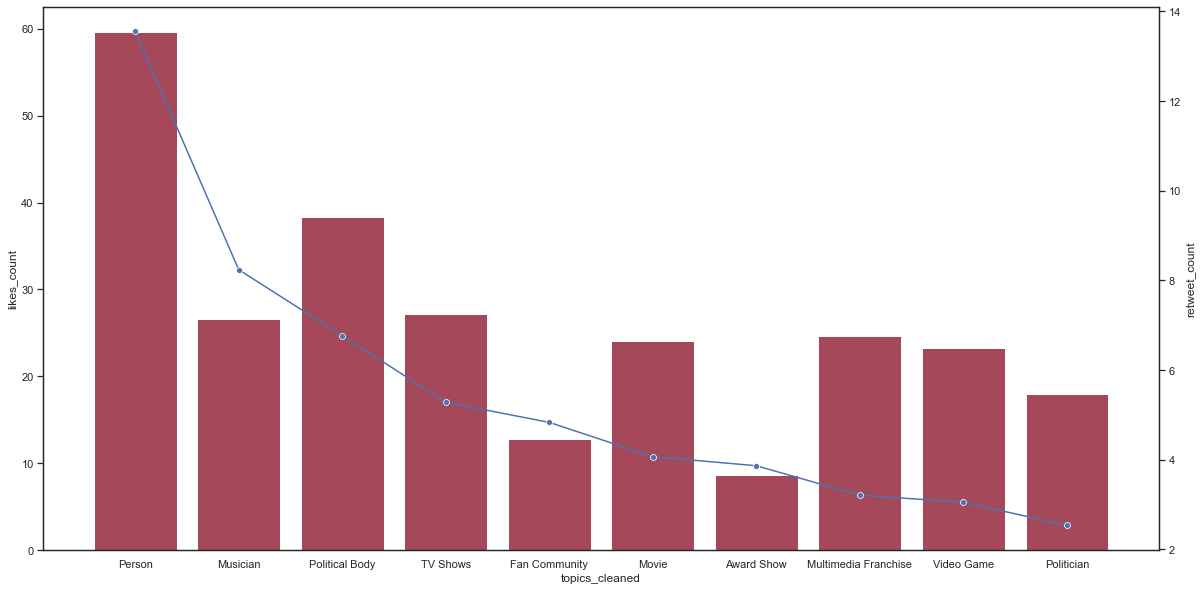

In [157]:
analysis_chart(topic_analysis1[:10], 'retweet_count', 'topics_cleaned', 'likes_count', 20)

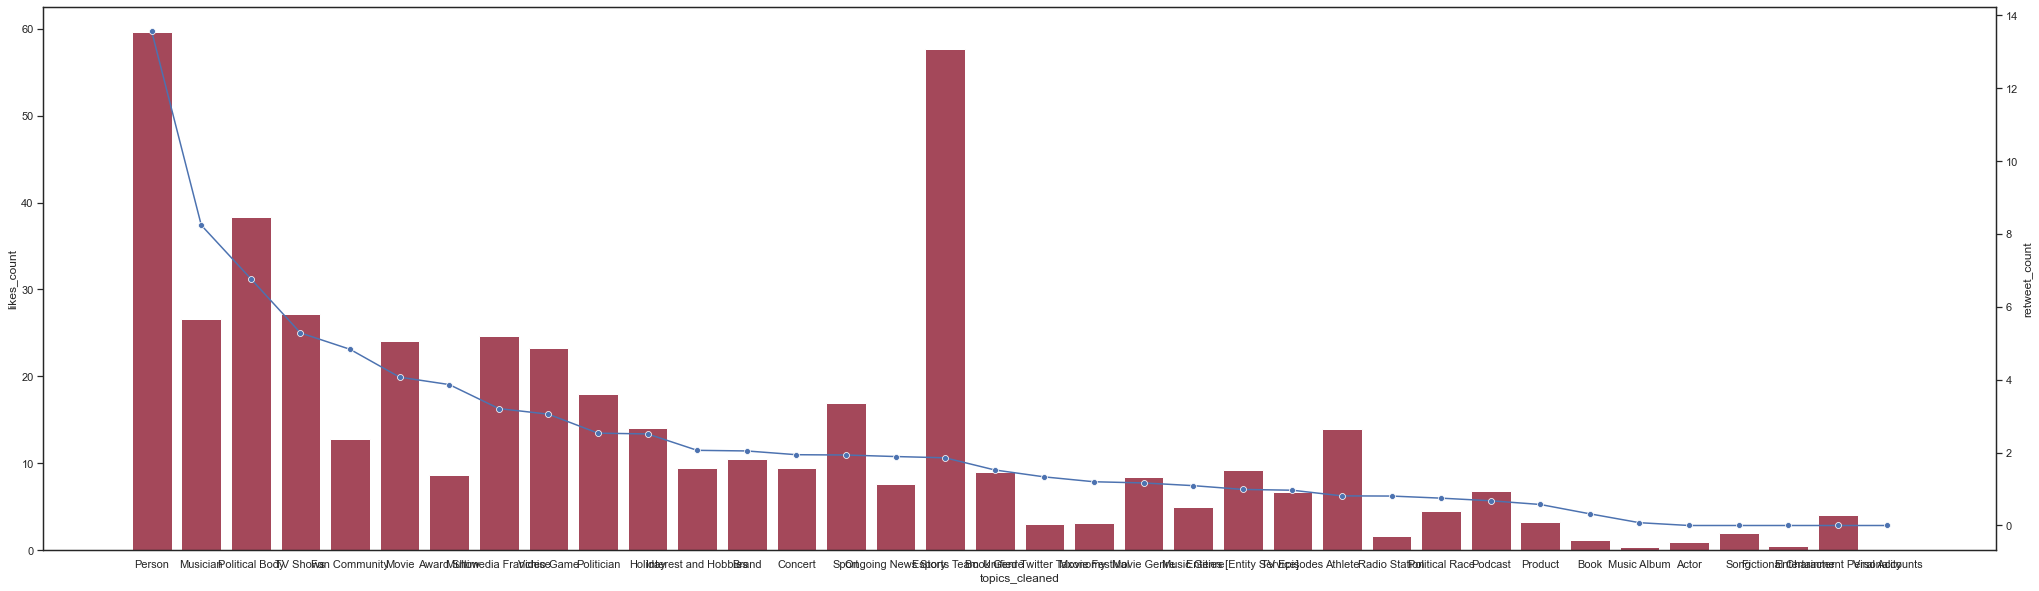

In [158]:
analysis_chart(topic_analysis1, 'retweet_count', 'topics_cleaned', 'likes_count', 35)

#### Topic performance by day of week

In [159]:
topic_analysis2 = topic_analysis.groupby(['day_of_week','topics_cleaned']).agg(
        retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
        likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['day_of_week']).reset_index()
topic_analysis2

,day_of_week,topics_cleaned,retweet_count,likes_count
0,Friday,Athlete,0.000000,0.600000
1,Friday,Viral Accounts,0.000000,0.000000
2,Friday,Video Game,2.564926,11.642570
3,Friday,Unified Twitter Taxonomy,0.250000,1.000000
4,Friday,TV Shows,2.980608,24.083737
...,...,...,...,...
216,Wednesday,Award Show,1.344262,1.704918
217,Wednesday,Athlete,2.000000,30.600000
218,Wednesday,Unified Twitter Taxonomy,0.000000,3.000000
219,Wednesday,Movie Genre,1.361111,3.861111


In [160]:
monday = topic_analysis2[topic_analysis2['day_of_week'] == 'Monday'].sort_values(by=['retweet_count'], ascending=False)
m = monday[:5]

tuesday = topic_analysis2[topic_analysis2['day_of_week'] == 'Tuesday'].sort_values(by=['retweet_count'], ascending=False)
t = tuesday[:5]

wednesday = topic_analysis2[topic_analysis2['day_of_week'] == 'Wednesday'].sort_values(by=['retweet_count'], ascending=False)
w = wednesday[:5]

thrusday = topic_analysis2[topic_analysis2['day_of_week'] == 'Thrusday'].sort_values(by=['retweet_count'], ascending=False)
th = thrusday[:5]

friday = topic_analysis2[topic_analysis2['day_of_week'] == 'Friday'].sort_values(by=['retweet_count'], ascending=False)
f = friday[:5]

saturday = topic_analysis2[topic_analysis2['day_of_week'] == 'Saturday'].sort_values(by=['retweet_count'], ascending=False)
s = saturday[:5]

sunday = topic_analysis2[topic_analysis2['day_of_week'] == 'Sunday'].sort_values(by=['retweet_count'], ascending=False)
su = sunday[:5]

In [161]:
x_bar_1 = m['day_of_week']
y_bar_1 = m['retweet_count']

x_bar_2 = t['day_of_week']
y_bar_2 = t['retweet_count']

x_bar_3 = w['day_of_week']
y_bar_3 = w['retweet_count']

x_bar_4 = th['day_of_week']
y_bar_4 = th['retweet_count']

x_bar_5 = f['day_of_week']
y_bar_5 = f['retweet_count']

x_bar_6 = s['day_of_week']
y_bar_6 = s['retweet_count']

x_bar_7 = su['day_of_week']
y_bar_7 = su['retweet_count']

day_monday = dict(type='bar', x=x_bar_1, y=y_bar_1, name='Monday', marker=dict(color='#E98E8E'), text=m['topics_cleaned'], textposition='auto', textfont=dict(color='black'))
day_tuesday = dict(type='bar', x=x_bar_2, y=y_bar_2, name='Tuesday', marker=dict(color='#7ecfd4'), text=t['topics_cleaned'], textposition='auto', textfont=dict(color='black'))
day_wednesday = dict(type='bar', x=x_bar_3, y=y_bar_3, name='Wednesday', marker=dict(color='#1184e8'), text=w['topics_cleaned'], textposition='auto', textfont=dict(color='black'))
day_thursday = dict(type='bar', x=x_bar_4, y=y_bar_4, name='Thrusday', marker=dict(color='#3c89d0'), text=th['topics_cleaned'], textposition='auto', textfont=dict(color='black'))
day_friday = dict(type='bar', x=x_bar_5, y=y_bar_5, name='Friday', marker=dict(color='crimson'), text=f['topics_cleaned'], textposition='auto', textfont=dict(color='black'))
day_saturday = dict(type='bar', x=x_bar_6, y=y_bar_6, name='Saturday', marker=dict(color='grey'), text=s['topics_cleaned'], textposition='auto', textfont=dict(color='black'))
day_sunday = dict(type='bar', x=x_bar_7, y=y_bar_7, name='Sunday', marker=dict(color='#76B041'), text=su['topics_cleaned'], textposition='auto', textfont=dict(color='black'))

days_of_week = [day_monday, day_tuesday, day_wednesday, day_thursday, day_friday, day_saturday, day_sunday]

#! pip install -U kaleido
import plotly.graph_objects as go

colors = {'Person': 'crimson',
          'Political Body': '#88c7dc',
          'Fan Community': 'E98E8E',
          'Movie': 'cornflowerblue',
          'Musician': 'DFA3A0',
          'Brand': 'A4CDE6'}

layout_days = dict(title=dict(text='Topic performance by day of the week'),
                    yaxis=dict(title='Retweets count'),
                    barmode='stack')
fig_daysplot = go.Figure(data=days_of_week, layout=layout_days)
fig_daysplot.show()

## Tweets performance in 2021

In [162]:
tweet_analysis = pd.DataFrame(data=df_2021[['day_phase', 'day_of_week', 'month', 'retweet_count', 'quote_count', 'like_count', 'topics', 'sentiment']])

### Retweet count per phase of the day chart

In [163]:
tweet_analysis1 = tweet_analysis.groupby(['day_phase']).agg(
    day_phase_count=pd.NamedAgg(column="day_phase", aggfunc="count"),
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['day_phase']).reset_index()
tweet_analysis1

,day_phase,day_phase_count,retweet_count,likes_count
0,Afternoon,105423,2.590782,13.170921
1,Dawn,105672,1.951529,12.122341
2,Evening,105747,1.953890,13.568659
3,Morning,104984,2.598558,12.562076
4,Night,105618,2.481746,16.871035


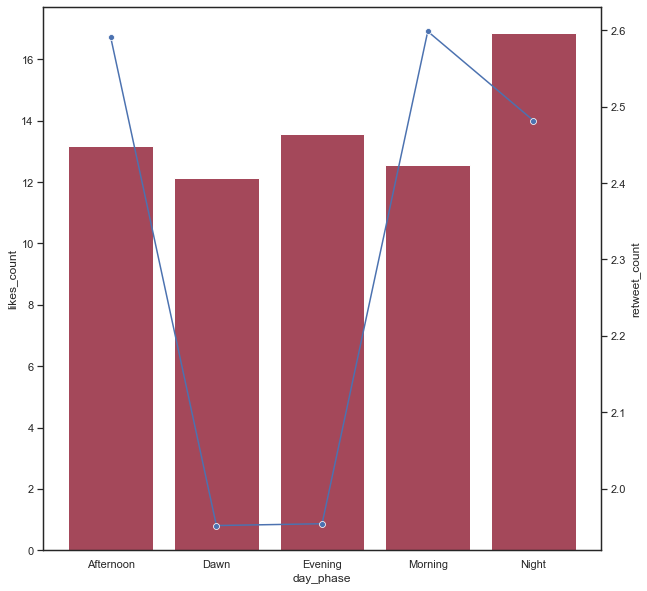

In [164]:
analysis_chart(tweet_analysis1, 'retweet_count', 'day_phase', 'likes_count', 10)

### Retweet count per day of the week

In [165]:
tweet_analysis2 = tweet_analysis.groupby(['day_of_week']).agg(
    day_of_week_count=pd.NamedAgg(column="day_of_week", aggfunc="count"),
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['day_of_week']).reset_index()
tweet_analysis2

,day_of_week,day_of_week_count,retweet_count,likes_count
0,Friday,76755,2.386841,14.005264
1,Monday,75057,2.432338,15.032842
2,Saturday,74940,1.944582,11.306472
3,Sunday,74948,2.409364,13.944308
4,Thursday,75249,2.069144,12.487183
5,Tuesday,75315,2.407967,13.074992
6,Wednesday,75180,2.550745,15.761732


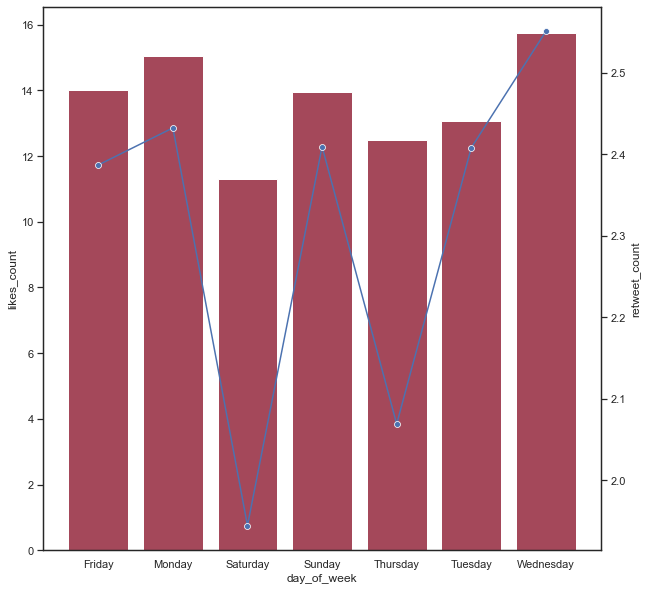

In [166]:
analysis_chart(tweet_analysis2, 'retweet_count', 'day_of_week', 'likes_count', 10)

### Retweet count per month

In [167]:
tweet_analysis3 = tweet_analysis.groupby(['month']).agg(
    month_count=pd.NamedAgg(column="month", aggfunc="count"),
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['month']).reset_index()
tweet_analysis3

,month,month_count,retweet_count,likes_count
0,April,42595,1.540251,9.540674
1,August,45264,1.919981,12.352377
2,December,45773,2.606580,16.452450
3,February,39404,2.744721,13.969089
4,January,43613,2.942494,18.449407
5,July,44938,2.295741,14.687325
6,June,43256,2.601720,12.607731
7,March,43796,1.988241,12.381679
8,May,44170,1.899117,11.295744
9,November,44354,2.654665,14.739505


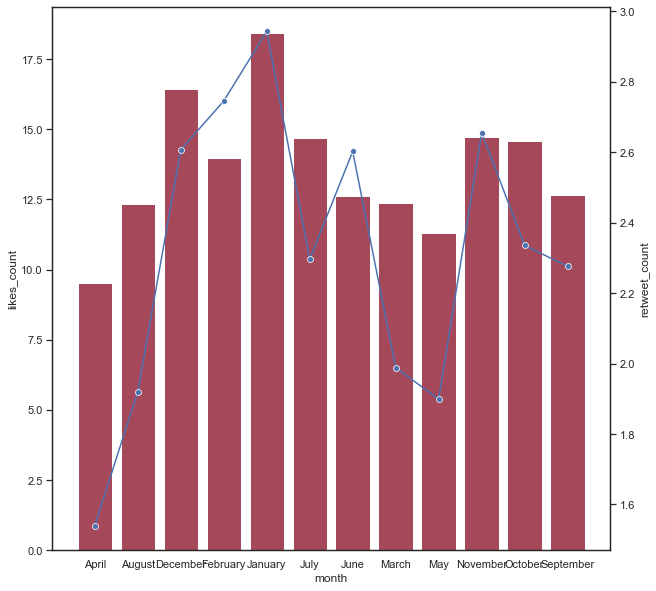

In [168]:
analysis_chart(tweet_analysis3, 'retweet_count', 'month', 'likes_count', 10)

### Tweets performance by sentiment

In [169]:
tweet_analysis4 = tweet_analysis.groupby(['sentiment']).agg(
    retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
    likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['retweet_count'],
                                                                              ascending=False).reset_index()
tweet_analysis4

,sentiment,retweet_count,likes_count
0,Positive,2.625396,15.348525
1,Negative,2.085727,11.959438
2,Neutral,2.072353,12.660516


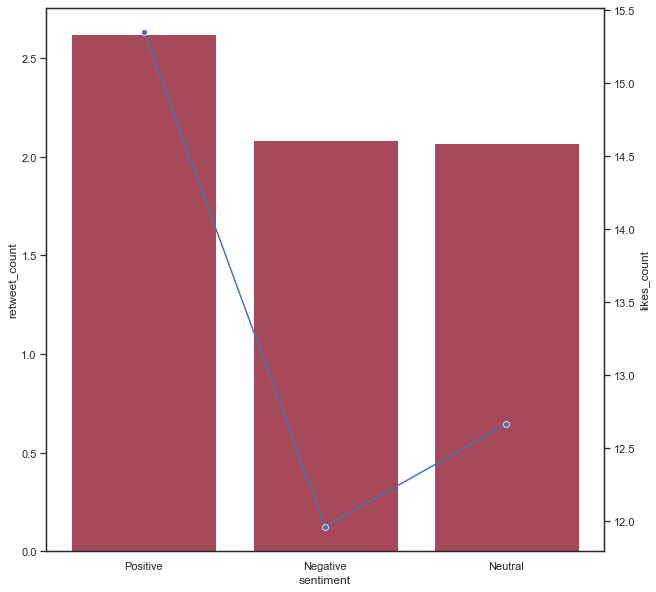

In [170]:
analysis_chart(tweet_analysis4, 'likes_count', 'sentiment', 'retweet_count', 10)

### Tweets performance by topics

In [171]:
topic_analysis = tweet_analysis[tweet_analysis['topics'] != '']
topic_analysis['topics_cleaned'] = topic_analysis['topics'].apply(lambda topic: clean_topics(topic))
topic_analysis

/Users/migueloliveira/PycharmProjects/SocialInsight/venv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,day_phase,day_of_week,month,retweet_count,quote_count,like_count,topics,sentiment,topics_cleaned
612352,Dawn,Friday,January,0,0,0,Holiday,Positive,Holiday
612349,Dawn,Friday,January,0,0,0,Brand Category,Neutral,Brand
612348,Dawn,Friday,January,0,0,1,Person,Neutral,Person
612353,Dawn,Friday,January,0,0,3,Video Game,Positive,Video Game
612355,Dawn,Friday,January,0,1,1,Holiday,Positive,Holiday
...,...,...,...,...,...,...,...,...,...
1056090,Night,Friday,December,0,0,0,Holiday,Positive,Holiday
1056091,Night,Friday,December,0,0,6,Holiday,Positive,Holiday
1056092,Night,Friday,December,0,0,7,Interests and Hobbies Vertical,Positive,Interest and Hobbies
1056097,Night,Friday,December,0,0,0,Brand Vertical,Neutral,Brand


In [172]:
topic_analysis['topics_cleaned'].value_counts(normalize=True)

Person                       0.226436
Interest and Hobbies         0.216452
Brand                        0.208607
TV Shows                     0.129461
Ongoing News Story           0.051408
Sport                        0.041458
Video Game                   0.028520
Holiday                      0.018581
Entities [Entity Service]    0.018473
Multimedia Franchise         0.015762
Music Genre                  0.010974
Political Body               0.007578
Fan Community                0.007312
Movie                        0.006039
Award Show                   0.004494
Book Genre                   0.002626
Movie Genre                  0.001907
Musician                     0.001760
Product                      0.000430
Esports Team                 0.000368
Unified Twitter Taxonomy     0.000351
Concert                      0.000170
Athlete                      0.000158
Book                         0.000141
Radio Station                0.000096
Podcast                      0.000096
TV Episodes 

In [173]:
topic_analysis2 = topic_analysis.groupby(['day_of_week','topics_cleaned']).agg(
        retweet_count=pd.NamedAgg(column="retweet_count", aggfunc="mean"),
        likes_count=pd.NamedAgg(column="like_count", aggfunc="mean")).sort_values(by=['day_of_week']).reset_index()
topic_analysis2

,day_of_week,topics_cleaned,retweet_count,likes_count
0,Friday,Athlete,0.000000,0.666667
1,Friday,Viral Accounts,0.000000,1.000000
2,Friday,Video Game,2.498667,17.748000
3,Friday,Unified Twitter Taxonomy,0.800000,1.200000
4,Friday,TV Shows,2.412824,18.586545
...,...,...,...,...
202,Wednesday,Book,0.200000,0.200000
203,Wednesday,Award Show,2.551724,6.735632
204,Wednesday,Athlete,0.000000,1.428571
205,Wednesday,Music Album,0.000000,2.500000


In [174]:
monday = topic_analysis2[topic_analysis2['day_of_week'] == 'Monday'].sort_values(by=['retweet_count'], ascending=False)
m = monday[:5]

tuesday = topic_analysis2[topic_analysis2['day_of_week'] == 'Tuesday'].sort_values(by=['retweet_count'], ascending=False)
t = tuesday[:5]

wednesday = topic_analysis2[topic_analysis2['day_of_week'] == 'Wednesday'].sort_values(by=['retweet_count'], ascending=False)
w = wednesday[:5]

thrusday = topic_analysis2[topic_analysis2['day_of_week'] == 'Thrusday'].sort_values(by=['retweet_count'], ascending=False)
th = thrusday[:5]

friday = topic_analysis2[topic_analysis2['day_of_week'] == 'Friday'].sort_values(by=['retweet_count'], ascending=False)
f = friday[:5]

saturday = topic_analysis2[topic_analysis2['day_of_week'] == 'Saturday'].sort_values(by=['retweet_count'], ascending=False)
s = saturday[:5]

sunday = topic_analysis2[topic_analysis2['day_of_week'] == 'Sunday'].sort_values(by=['retweet_count'], ascending=False)
su = sunday[:5]

In [175]:
x_bar_1 = m['day_of_week']
y_bar_1 = m['retweet_count']

x_bar_2 = t['day_of_week']
y_bar_2 = t['retweet_count']

x_bar_3 = w['day_of_week']
y_bar_3 = w['retweet_count']

x_bar_4 = th['day_of_week']
y_bar_4 = th['retweet_count']

x_bar_5 = f['day_of_week']
y_bar_5 = f['retweet_count']

x_bar_6 = s['day_of_week']
y_bar_6 = s['retweet_count']

x_bar_7 = su['day_of_week']
y_bar_7 = su['retweet_count']

day_monday = dict(type='bar', x=x_bar_1, y=y_bar_1, name='Monday', marker=dict(color='#E98E8E'), text=m['topics_cleaned'], textposition='auto', textfont=dict(color='black'))
day_tuesday = dict(type='bar', x=x_bar_2, y=y_bar_2, name='Tuesday', marker=dict(color='#7ecfd4'), text=t['topics_cleaned'], textposition='auto', textfont=dict(color='black'))
day_wednesday = dict(type='bar', x=x_bar_3, y=y_bar_3, name='Wednesday', marker=dict(color='#1184e8'), text=w['topics_cleaned'], textposition='auto', textfont=dict(color='black'))
day_thursday = dict(type='bar', x=x_bar_4, y=y_bar_4, name='Thrusday', marker=dict(color='#3c89d0'), text=th['topics_cleaned'], textposition='auto', textfont=dict(color='black'))
day_friday = dict(type='bar', x=x_bar_5, y=y_bar_5, name='Friday', marker=dict(color='crimson'), text=f['topics_cleaned'], textposition='auto', textfont=dict(color='black'))
day_saturday = dict(type='bar', x=x_bar_6, y=y_bar_6, name='Saturday', marker=dict(color='grey'), text=s['topics_cleaned'], textposition='auto', textfont=dict(color='black'))
day_sunday = dict(type='bar', x=x_bar_7, y=y_bar_7, name='Sunday', marker=dict(color='#76B041'), text=su['topics_cleaned'], textposition='auto', textfont=dict(color='black'))

days_of_week = [day_monday, day_tuesday, day_wednesday, day_thursday, day_friday, day_saturday, day_sunday]

#! pip install -U kaleido
import plotly.graph_objects as go

colors = {'Person': 'crimson',
          'Political Body': '#88c7dc',
          'Fan Community': 'E98E8E',
          'Movie': 'cornflowerblue',
          'Musician': 'DFA3A0',
          'Brand': 'A4CDE6'}

layout_days = dict(title=dict(text='Topic performance by day of the week'),
                    yaxis=dict(title='Retweets count'),
                    barmode='stack')
fig_daysplot = go.Figure(data=days_of_week, layout=layout_days)
fig_daysplot.show()

## Outliers

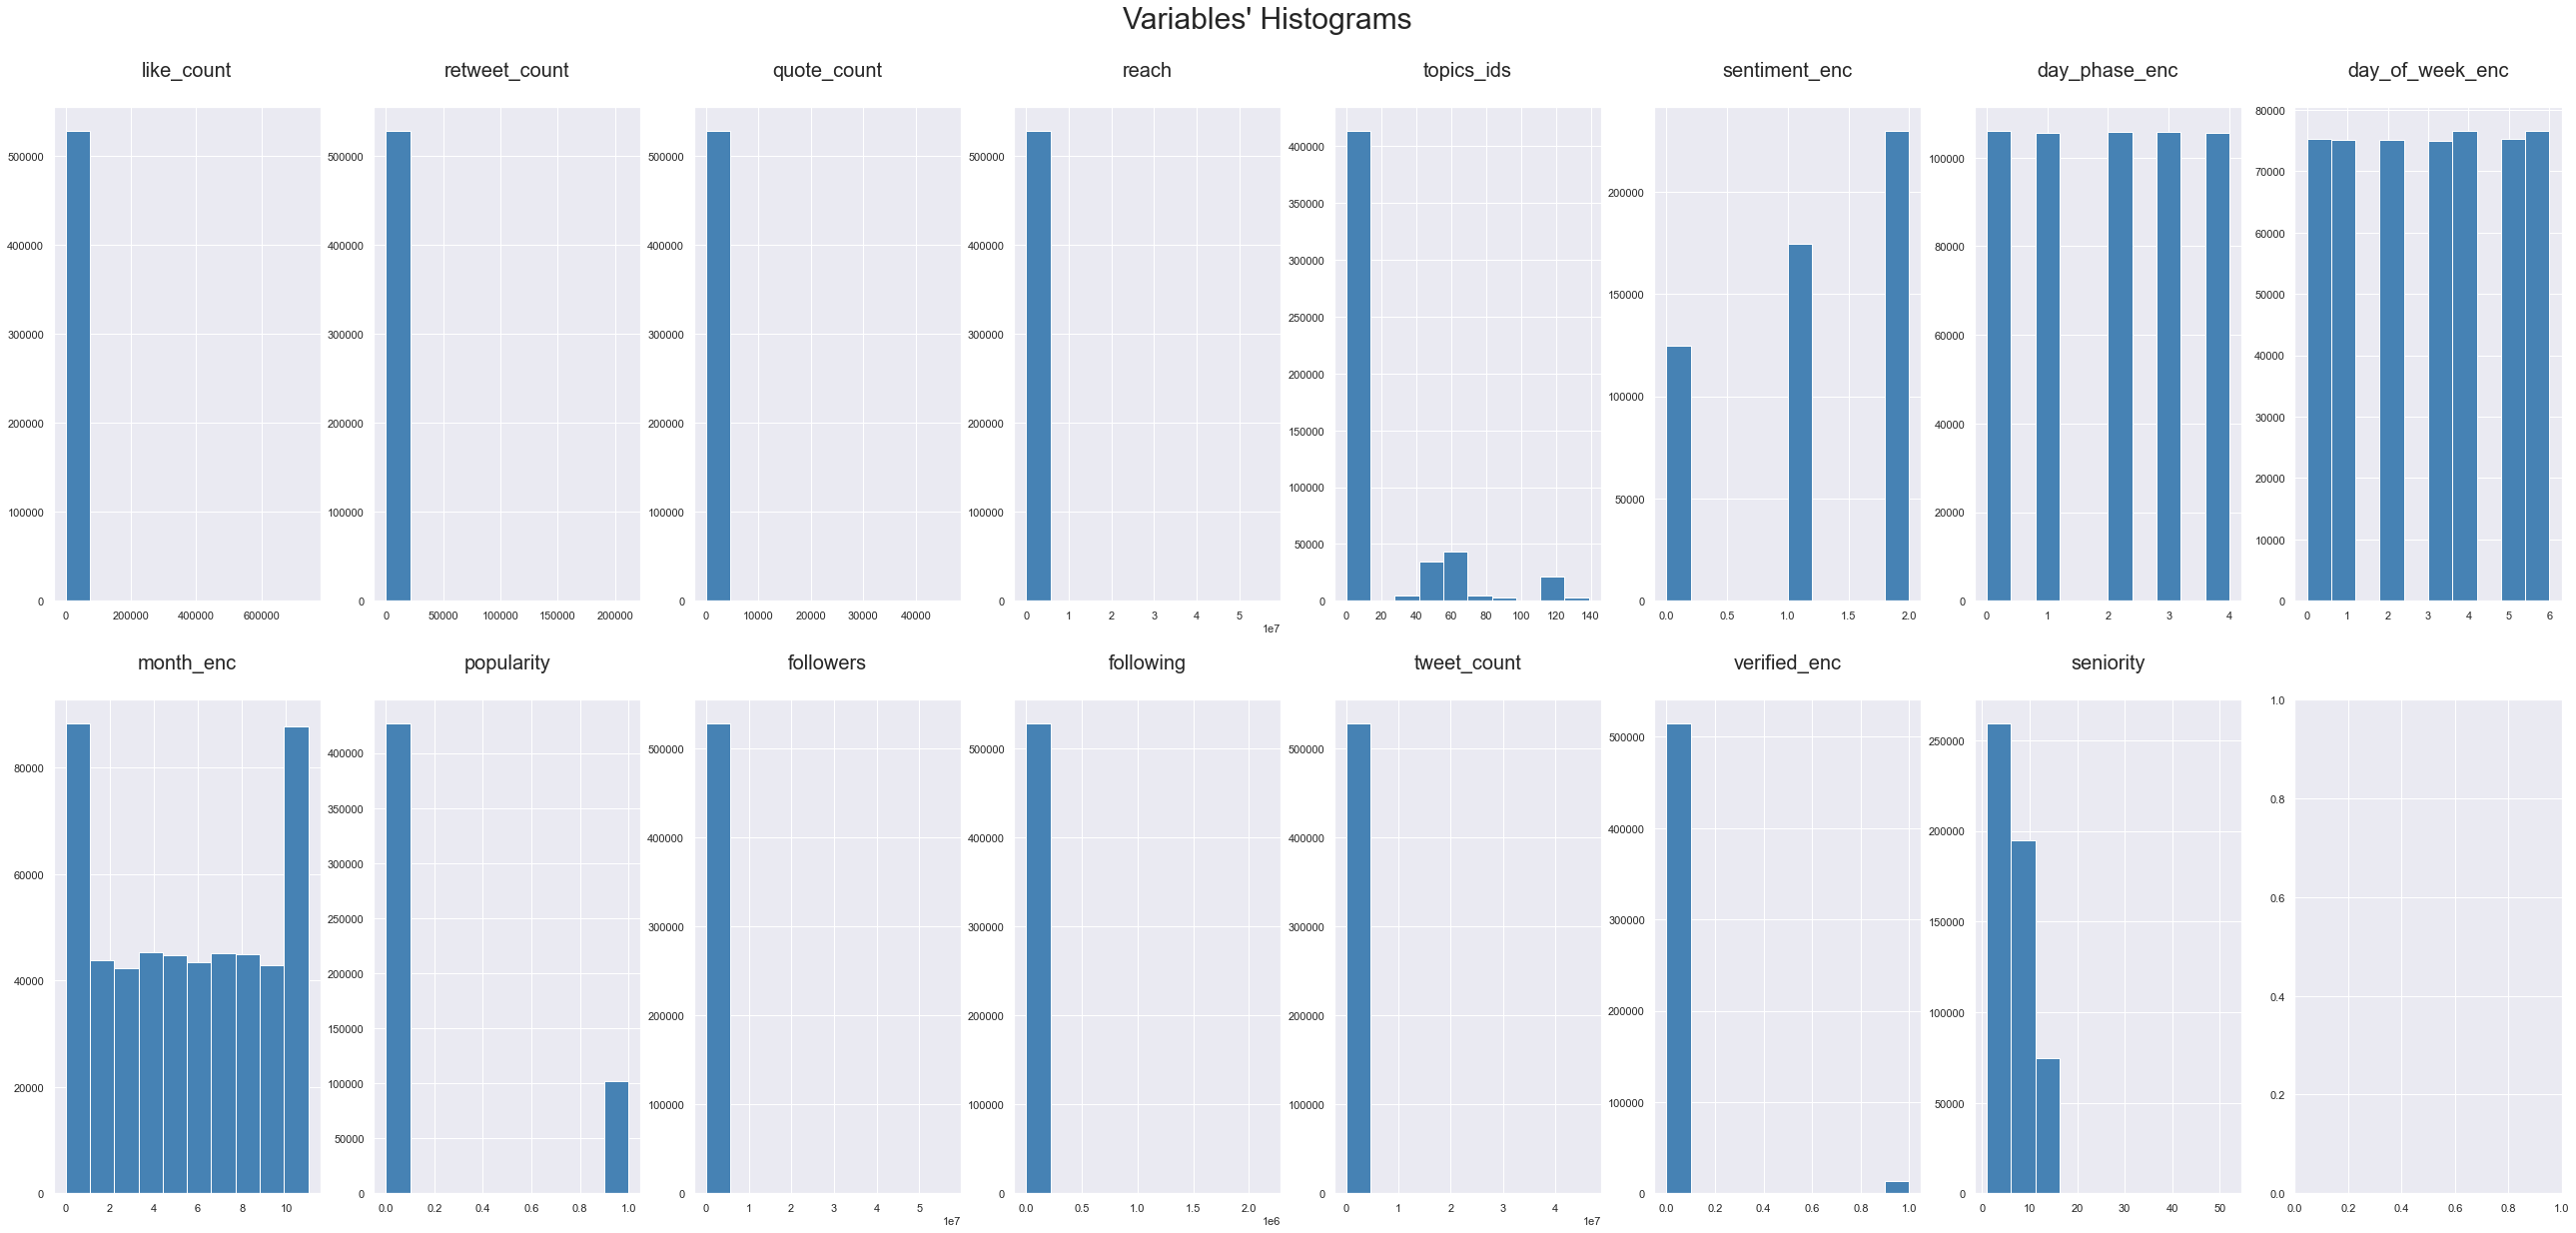

In [176]:
var_outliers = vars
sns.set()
fig, axes = plt.subplots(2, math.ceil(len(var_outliers) / 2), figsize=(45, 20))

for ax, feat in zip(axes.flatten(), var_outliers):
    ax.hist(df_2020[feat], color='steelblue')
    ax.set_title(feat, y=1.05, fontsize=20)

title = "Variables' Histograms"
plt.suptitle(title, y=0.95, fontsize=30)
plt.show()

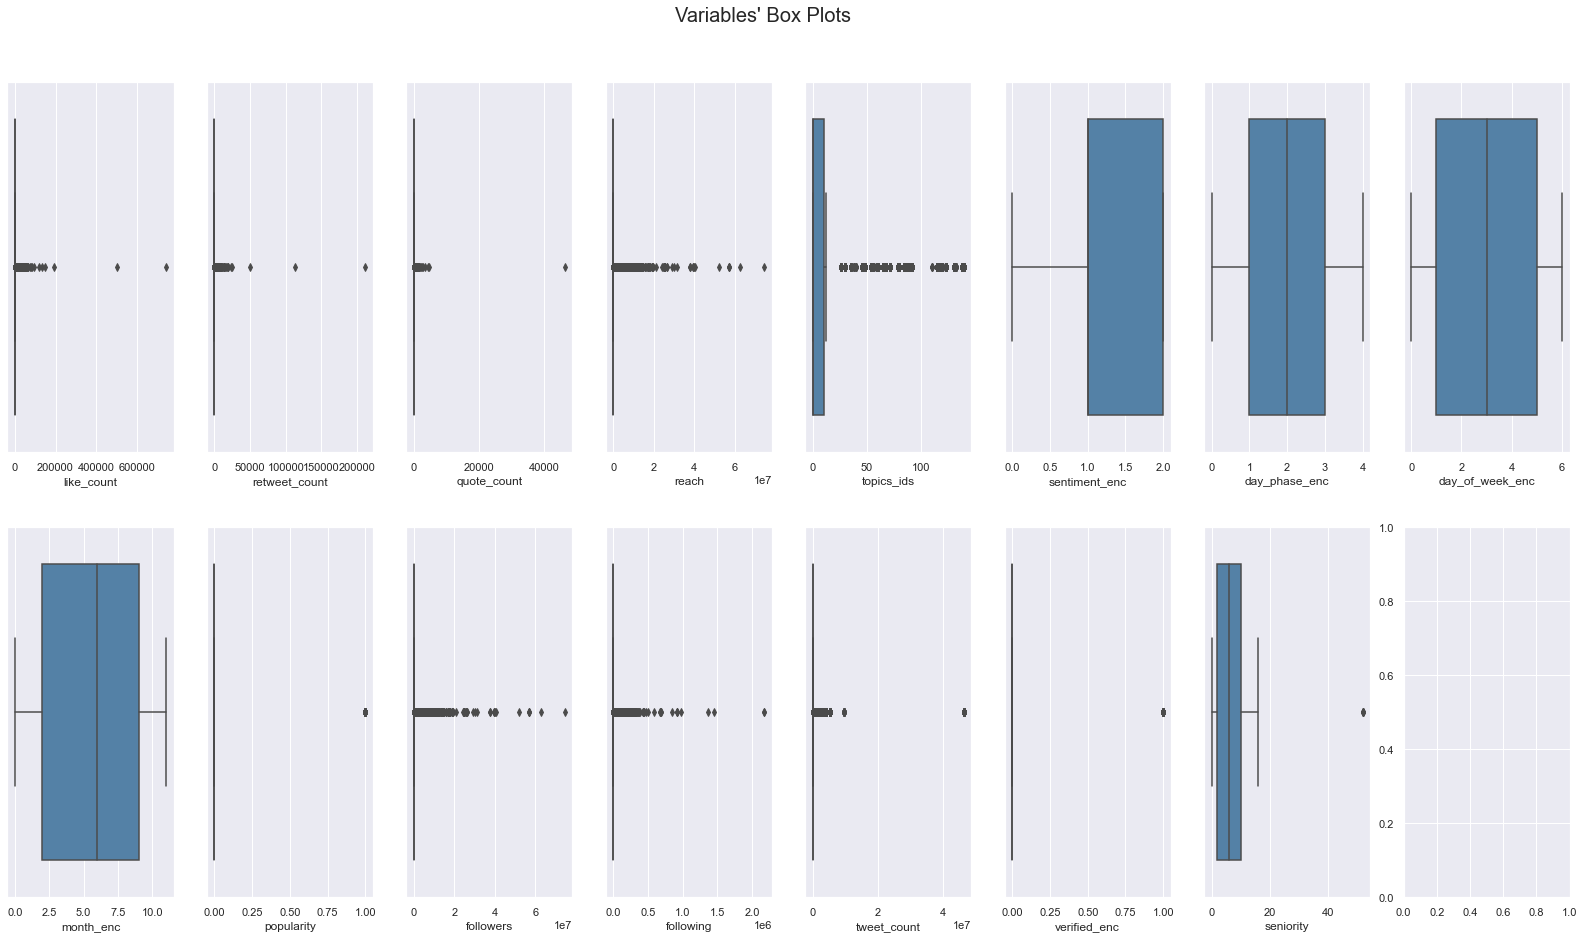

In [177]:
sns.set()
fig, axes = plt.subplots(2, math.ceil(len(var_outliers) / 2), figsize=(28, 15))

for ax, feat in zip(axes.flatten(), var_outliers):
    sns.boxplot(x=df[feat], ax=ax, color='steelblue')

title = "Variables' Box Plots"
plt.suptitle(title, y=0.95, fontsize=20)
plt.show()

## Clustering algorithms

### Data Standardization

In [178]:
df=df.reset_index(drop=True)

In [179]:
def fetch_by_week(week_data):
    tweets_per_week = len(week_data)
    print("total tweets per week:", tweets_per_week)
    if tweets_per_week >= 250:
        return week_data[:250]
    else:
        return week_data

In [180]:
year_2020_sample = df_2020.groupby('week_idx').apply(fetch_by_week).reset_index(drop=True)
year_2020_sample

total tweets per week: 7266
total tweets per week: 10229
total tweets per week: 10226
total tweets per week: 10231
total tweets per week: 10197
total tweets per week: 10207
total tweets per week: 10214
total tweets per week: 10199
total tweets per week: 10234
total tweets per week: 10209
total tweets per week: 10207
total tweets per week: 10213
total tweets per week: 10193
total tweets per week: 10205
total tweets per week: 10174
total tweets per week: 10184
total tweets per week: 10200
total tweets per week: 10184
total tweets per week: 10143
total tweets per week: 10158
total tweets per week: 10170
total tweets per week: 10189
total tweets per week: 10158
total tweets per week: 10098
total tweets per week: 10127
total tweets per week: 10137
total tweets per week: 10161
total tweets per week: 10103
total tweets per week: 10105
total tweets per week: 10123
total tweets per week: 10124
total tweets per week: 10123
total tweets per week: 10086
total tweets per week: 10075
total tweets pe

,Unnamed: 0,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,...,day_of_week,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc,seniority
0,0,1212176606699180032,IM READY FOR BTS,2020-01-01 00:59:58,1078318888851513347,0,0,0,0,100,...,Wednesday,Dawn,2020-01,1,6,4,0,2,0,3
1,1044,1212176605629632513,2 people followed me and 4 people unfollowed m...,2020-01-01 00:59:58,255042521,0,0,0,0,257,...,Wednesday,Dawn,2020-01,1,6,4,0,1,0,11
2,1042,1212176605650542592,The way she ate every single role un these pho...,2020-01-01 00:59:58,288954365,1,1,0,0,575,...,Wednesday,Dawn,2020-01,1,6,4,0,1,0,10
3,1041,1212176605684097026,Por favor y reina de no hacer playback https:/...,2020-01-01 00:59:58,827231822,1,0,1,0,1425,...,Wednesday,Dawn,2020-01,1,6,4,0,2,0,9
4,1040,1212176605742809088,I always find myself iterating upon “that’s no...,2020-01-01 00:59:58,1891705003,1,0,0,0,729,...,Wednesday,Dawn,2020-01,1,6,4,0,1,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13245,422433,1343361016298672130,weather data 8:00 PM 36.8 73 pct 0.0 ENE,2020-12-28 00:59:59+00:00,90083667,0,0,0,0,17,...,Monday,Dawn,2020-53,1,1,2,0,1,0,12
13246,607164,1343361015690485765,nothing is stopping me. https://t.co/vry8LQIZyZ,2020-12-28 00:59:59+00:00,1340128671038902273,0,0,1,0,399,...,Monday,Dawn,2020-53,1,1,2,0,2,0,1
13247,600974,1343361017166888960,"""A man who is 100% sane is dead."" ~ Osho",2020-12-28 00:59:59+00:00,3260285413,224,43,2,3,87948,...,Monday,Dawn,2020-53,1,1,2,0,0,0,6
13248,30222,1343361015145091074,“There are books of which the backs and covers...,2020-12-28 00:59:59+00:00,1388911082,0,0,0,0,51,...,Monday,Dawn,2020-53,1,1,2,0,2,0,8


In [181]:
year_2021_sample = df_2021.groupby('week_idx').apply(fetch_by_week).reset_index(drop=True)
year_2021_sample

total tweets per week: 9877
total tweets per week: 9835
total tweets per week: 9807
total tweets per week: 9855
total tweets per week: 9780
total tweets per week: 9921
total tweets per week: 9896
total tweets per week: 9807
total tweets per week: 9800
total tweets per week: 9891
total tweets per week: 9892
total tweets per week: 9932
total tweets per week: 9967
total tweets per week: 9913
total tweets per week: 9972
total tweets per week: 9904
total tweets per week: 9957
total tweets per week: 9934
total tweets per week: 9998
total tweets per week: 9992
total tweets per week: 9991
total tweets per week: 10041
total tweets per week: 10093
total tweets per week: 10068
total tweets per week: 10124
total tweets per week: 10126
total tweets per week: 10112
total tweets per week: 10158
total tweets per week: 10136
total tweets per week: 10199
total tweets per week: 10204
total tweets per week: 10212
total tweets per week: 10248
total tweets per week: 10219
total tweets per week: 10294
total 

,Unnamed: 0,tweet_id,text,timestamp,user_id,like_count,retweet_count,quote_count,reply_count,reach,...,day_of_week,day_phase,week_idx,day_phase_enc,day_of_week_enc,month_enc,year_enc,sentiment_enc,verified_enc,seniority
0,616232,1345897728904228866,Im convinced Ronaldo is an alien bro.😤😭🔥,2021-01-04 00:59:58+00:00,762283225221894144,0,0,0,0,1047,...,Monday,Dawn,2021-01,1,1,4,1,0,0,5
1,616234,1345897728937779202,the princess herself miss fischl has a complet...,2021-01-04 00:59:58+00:00,1243947493274128384,3,0,0,1,188,...,Monday,Dawn,2021-01,1,1,4,1,0,0,1
2,616235,1345897728958730242,Listen this song :) Fancy Girls by Pr3$Ly htt...,2021-01-04 00:59:58+00:00,1473425724,0,0,0,0,1805,...,Monday,Dawn,2021-01,1,1,4,1,2,0,8
3,616236,1345897728853815298,"I'm watching Supernatural 1x16 ""Shadow"" https:...",2021-01-04 00:59:58+00:00,3029091592,0,0,0,0,1564,...,Monday,Dawn,2021-01,1,1,4,1,1,0,7
4,616237,1345897728962932736,Ever had a crush on? 1. yes 2. yes 3. yes Al...,2021-01-04 00:59:58+00:00,23709832,2,0,0,0,538,...,Monday,Dawn,2021-01,1,1,4,1,0,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13245,324711,1344810569296035840,I had 9 different hair colours this year. 😅,2021-01-01 00:59:59+00:00,411257104,3,0,0,1,269,...,Friday,Dawn,2021-53,1,0,4,1,2,0,10
13246,324857,1344810569577074688,"Happy New Year from me, my friends, and a spec...",2021-01-01 00:59:59+00:00,4184060020,13,0,1,7,3933,...,Friday,Dawn,2021-53,1,0,4,1,2,0,6
13247,2439,1344810570067963904,Strong Stocks Learn how to find the strongest...,2021-01-01 00:59:59+00:00,121370906,0,0,0,0,8398,...,Friday,Dawn,2021-53,1,0,4,1,2,0,12
13248,279607,1344810569367506945,"Happy New Year to all my Friends, Followers, a...",2021-01-01 00:59:59+00:00,3436615415,12,1,0,0,8125,...,Friday,Dawn,2021-53,1,0,4,1,2,0,6


#### 2020 values

In [182]:
scaler = MinMaxScaler()
value = year_2020_sample[users_vars].reindex()
value_scaled = scaler.fit_transform(value)
value_scaled = pd.DataFrame(value_scaled, columns=value.columns)

pref = year_2020_sample[tweet_vars].reindex()
pref_scaled = scaler.fit_transform(pref)
pref_scaled = pd.DataFrame(pref_scaled, columns=pref.columns)

#### 2021 values

In [183]:
value_2021 = year_2021_sample[users_vars].reindex()
value_scaled_2021 = scaler.fit_transform(value_2021)
value_scaled_2021 = pd.DataFrame(value_scaled_2021, columns=value_2021.columns)
pref_2021 = year_2021_sample[tweet_vars].reindex()
pref_scaled_2021 = scaler.fit_transform(pref_2021)
pref_scaled_2021 = pd.DataFrame(pref_scaled_2021, columns=pref_2021.columns)

### Value view - Tweets data

#### HC + K-means

In [184]:
hclust_value = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=5)
hclust_value_labels = hclust_value.fit_predict(value_scaled)
hclust_value_labels

array([3, 1, 1, ..., 0, 4, 3])

In [185]:
# Computing SST
X = value_scaled.values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
#iterate over each cluster and get the ssw
for i in np.unique(hclust_value_labels):
    X_k = X[hclust_value_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hclust_value_labels):
    X_k = X[hclust_value_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True,  True,  True])

In [186]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    def get_ss(df):
        ss = np.sum(df.var() * (df.shape[0] - 1))
        return ss
    sst = get_ss(df)  # get total sum of squares
    r2 = []
    for i in range(min_nclus, max_nclus + 1):
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df)
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)
        ssb = sst - np.sum(ssw_labels)
        r2.append(ssb / sst)
    return np.array(r2)

In [187]:
get_r2_hc(value_scaled, 'ward', 10, min_nclus=1, dist="euclidean")

array([0.        , 0.61243361, 0.81882955, 0.90170473, 0.94159962,
       0.9560887 , 0.97005848, 0.97626107, 0.98130693, 0.98373143])

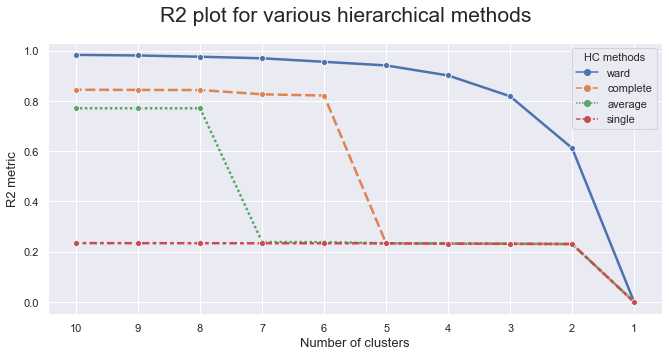

In [188]:
hc_methods = ["ward", "complete", "average", "single"]

max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(value_scaled, link, max_nclus, min_nclus=1, dist="euclidean")
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [189]:
linkage = 'ward'
distance = 'euclidean'

# Define the clusterer
hclust = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage, affinity=distance)
hclust.fit_predict(value_scaled)

array([10936,  7872,  7403, ...,     1,     2,     0])

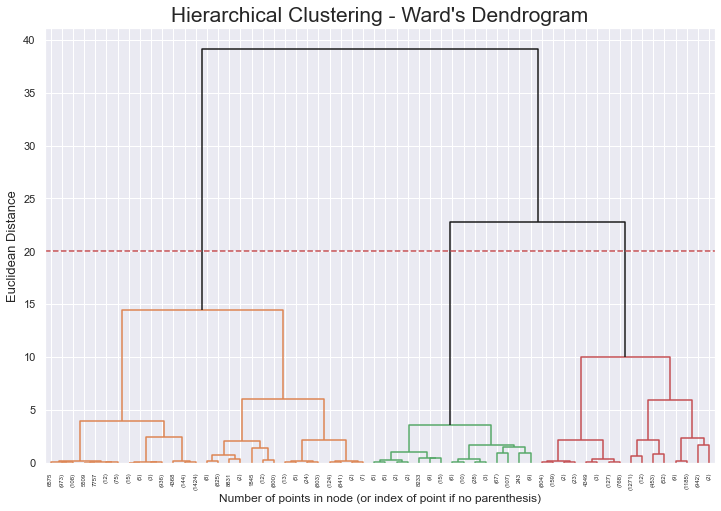

In [190]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

sns.set()
fig = plt.figure(figsize=(12, 8))

y_threshold = 20
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [191]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(n_clusters=4, linkage=linkage, affinity=distance)
hc_val_labels = hclust.fit_predict(value_scaled)

In [192]:
val_concat = pd.concat((value, pd.Series(hc_val_labels, name='labels')), axis=1)
val_concat.groupby('labels').mean()

,followers,following,tweet_count,verified_enc,seniority
labels,,,,,
0,3131.275933,1542.104249,74537.357991,0.0,10.396353
1,1962.626298,1134.040369,65584.229527,0.0,5.428777
2,195179.551852,3800.292593,100900.874074,1.0,10.925926
3,1694.108678,713.109759,20992.434982,0.0,2.057313


In [193]:
pd.Series(hc_val_labels).value_counts()

0    5813
3    3699
1    3468
2     270
dtype: int64

In [194]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

In [195]:
sst = get_ss(value)
ssw_labels = val_concat.groupby(by='labels').apply(get_ss)
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

0.006662925386670157

In [196]:
#### DBSCAN

In [197]:
neighbors = NearestNeighbors(n_neighbors=15)
neighbors_fit = neighbors.fit(value_scaled)
distances, indices = neighbors_fit.kneighbors(value_scaled)

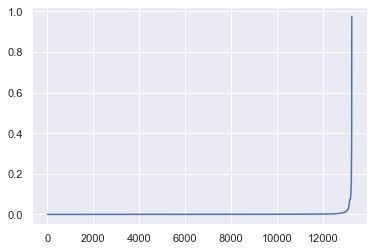

In [198]:
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [199]:
dbscan = DBSCAN(eps=0.15, min_samples=20, n_jobs=4)
dbscan_value_labels = dbscan.fit_predict(value_scaled)
dbscan_n_clusters = len(np.unique(dbscan_value_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

dbscan_value_concat = pd.concat([value, pd.Series(dbscan_value_labels, index=value_scaled.index, name="dbscan_labels")],
                                axis=1)
dbscan_value_concat.head()

Number of estimated clusters : 3


,followers,following,tweet_count,verified_enc,seniority,dbscan_labels
0,100,390,3961,0,3,0
1,257,1028,4807,0,11,0
2,575,1316,69233,0,10,0
3,1425,515,307238,0,9,0
4,729,231,12946,0,8,0


In [200]:
Counter(dbscan_value_labels)

Counter({0: 12974, 1: 264, -1: 12})

In [201]:
df_nonoise = dbscan_value_concat.loc[dbscan_value_concat['dbscan_labels'] != -1]

sst = get_ss(value)
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

0.883002680799897

In [202]:
### Preferences view - Tweet's users

In [203]:
####  HC + K-means

In [204]:
hclust_pref = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=5)
hclust_pref_labels = hclust_pref.fit_predict(pref_scaled)
hclust_pref_labels

array([0, 0, 0, ..., 0, 3, 3])

In [205]:
# Computing SST
X = pref_scaled.values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
#iterate over each cluster and get the ssw
for i in np.unique(hclust_value_labels):
    X_k = X[hclust_value_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hclust_pref_labels):
    X_k = X[hclust_pref_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True,  True, False,  True, False, False])

In [206]:
get_r2_hc(pref_scaled, 'ward', 10, min_nclus=1, dist="euclidean")

array([0.        , 0.43057203, 0.58607423, 0.68195564, 0.76311718,
       0.83515164, 0.88377757, 0.91426342, 0.93193684, 0.94272563])

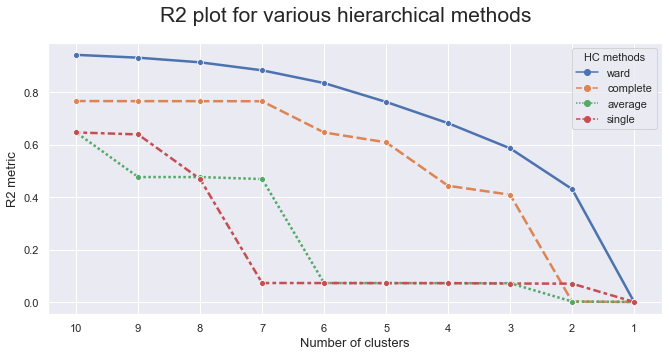

In [207]:
hc_methods = ["ward", "complete", "average", "single"]

max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(pref_scaled, link, max_nclus, min_nclus=1, dist="euclidean")
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11, 5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"] * 4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [208]:
linkage = 'ward'
distance = 'euclidean'

# Define the clusterer
hclust = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage, affinity=distance)
hclust.fit_predict(pref_scaled)

array([ 9794,  8148, 10927, ...,     2,     1,     0])

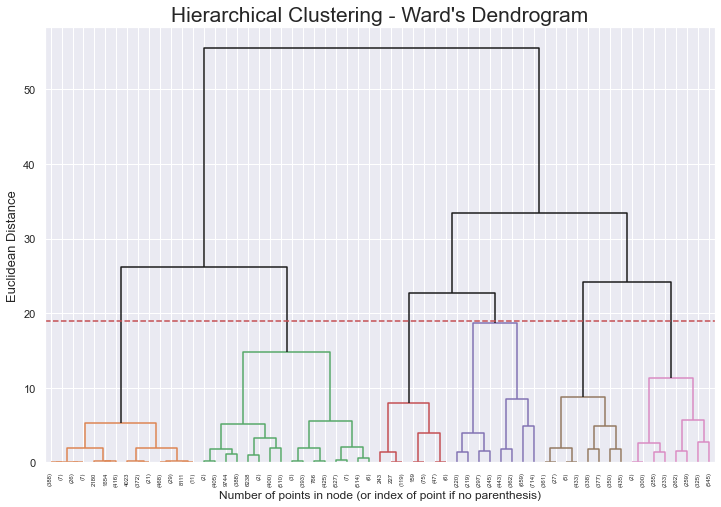

In [209]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

sns.set()
fig = plt.figure(figsize=(12, 8))

y_threshold = 19
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [210]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(n_clusters=4, linkage=linkage, affinity=distance)
hc_pref_labels = hclust.fit_predict(pref_scaled)

In [211]:
pref_concat = pd.concat((pref, pd.Series(hc_pref_labels, name='labels')), axis=1)
pref_concat.groupby('labels').mean()

,like_count,retweet_count,quote_count,reach,sentiment_enc,day_phase_enc,day_of_week_enc,month_enc
labels,,,,,,,,
0,4.663634,0.598402,0.096960,4689.312181,0.516086,1.0,1.000000,7.949634
1,26.430962,3.678661,0.260251,6944.878940,1.999721,1.0,1.000000,7.446304
2,8.630390,1.254327,0.114696,8864.156351,0.732180,1.0,1.366676,2.231446
3,6.514580,1.116066,0.082333,4415.924528,2.000000,1.0,1.000000,1.497427


In [212]:
pd.Series(hc_pref_labels).value_counts()
sst = get_ss(pref)
ssw_labels = pref_concat.groupby(by='labels').apply(get_ss)
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

0.0002921504462549666

#### DBSCAN

In [213]:
neighbors = NearestNeighbors(n_neighbors=15)
neighbors_fit = neighbors.fit(pref_scaled)
distances, indices = neighbors_fit.kneighbors(pref_scaled)

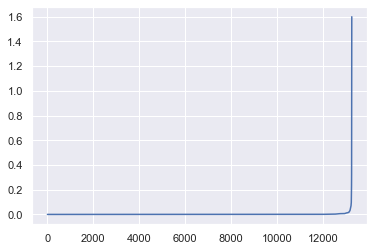

In [214]:
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [215]:
dbscan = DBSCAN(eps=0.25, min_samples=500, n_jobs=4)
dbscan_pref_labels = dbscan.fit_predict(pref_scaled)
dbscan_n_clusters = len(np.unique(dbscan_pref_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

dbscan_pref_concat = pd.concat([pref, pd.Series(dbscan_pref_labels, index=pref_scaled.index, name="dbscan_labels")],
                               axis=1)
dbscan_pref_concat.head()

Number of estimated clusters : 4


,like_count,retweet_count,quote_count,reach,sentiment_enc,day_phase_enc,day_of_week_enc,month_enc,dbscan_labels
0,0,0,0,100,2,1,6,4,-1
1,0,0,0,257,1,1,6,4,-1
2,1,1,0,575,1,1,6,4,-1
3,1,0,1,1425,2,1,6,4,-1
4,1,0,0,729,1,1,6,4,-1


In [216]:
Counter(dbscan_pref_labels)
df_nonoise = dbscan_pref_concat.loc[dbscan_pref_concat['dbscan_labels'] != -1]

In [217]:
sst = get_ss(pref)
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

0.8247835738564838

### Clusters

In [218]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    if compar_titles == None:
        compar_titles = [""] * len(label_columns)
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i != label]
        dfax = df.drop(drop_cols, axis=1)

        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:, [0, 1]]
        counts.columns = [label, "counts"]

        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95, 1.1), xycoords='axes fraction', fontsize=13, fontweight='heavy')
        ax[0].legend(handles, cluster_labels)  # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)

    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.show()

### Value View - 2020

In [219]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(n_clusters=4, linkage=linkage, affinity=distance)
hc_val_labels = hclust.fit_predict(value_scaled)

val_concat = pd.concat((value, pd.Series(hc_val_labels, name='labels')), axis=1)
val_concat.groupby('labels').mean()

,followers,following,tweet_count,verified_enc,seniority
labels,,,,,
0,3131.275933,1542.104249,74537.357991,0.0,10.396353
1,1962.626298,1134.040369,65584.229527,0.0,5.428777
2,195179.551852,3800.292593,100900.874074,1.0,10.925926
3,1694.108678,713.109759,20992.434982,0.0,2.057313


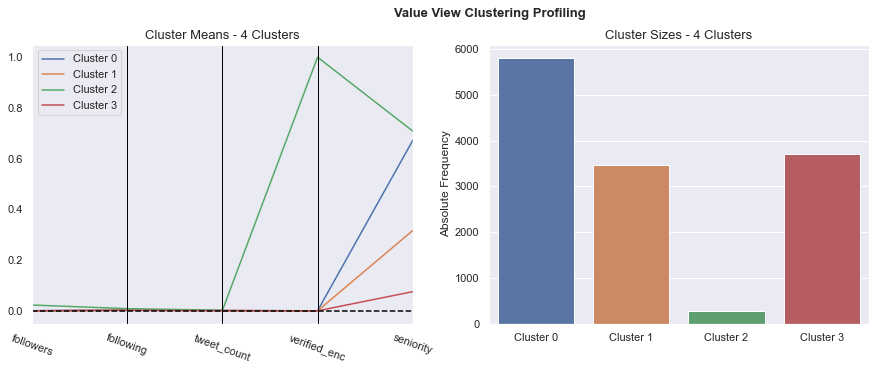

In [220]:
# Profilling each cluster
val_concat_scaled = pd.concat((value_scaled, pd.Series(hc_val_labels, name='labels')), axis=1)
cluster_profiles(df=val_concat_scaled, label_columns=['labels'], figsize=(15, 5),
                 compar_titles=['Value View Clustering Profiling'])

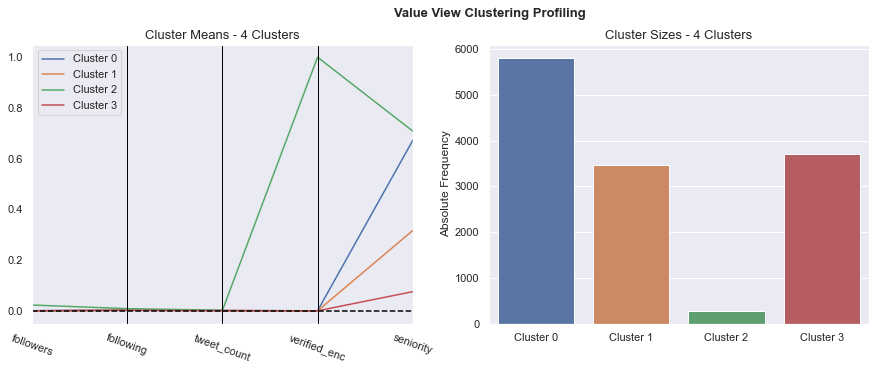

In [221]:
# Profilling each cluster
val_concat_scaled = pd.concat((value_scaled, pd.Series(hc_val_labels, name='labels')), axis=1)
cluster_profiles(df=val_concat_scaled , label_columns = ['labels'],figsize = (15, 5),compar_titles = ['Value View Clustering Profiling'])

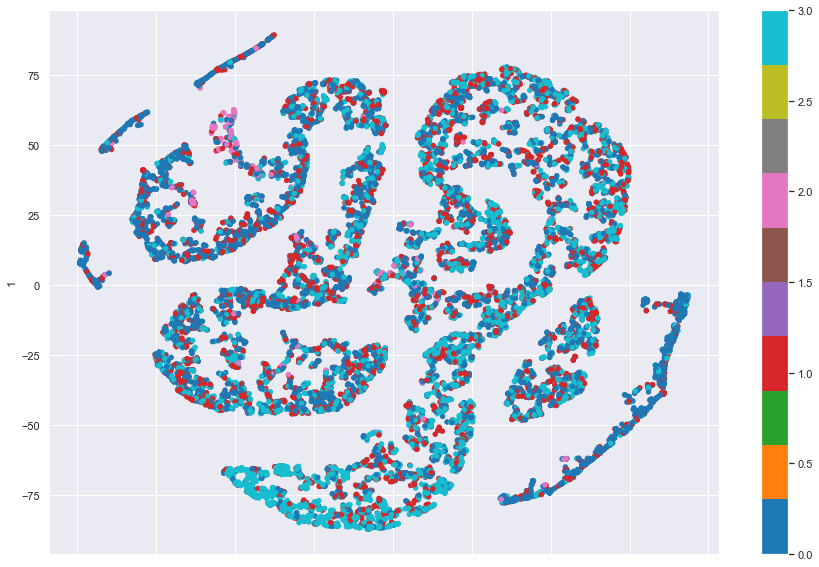

In [222]:
two_dim = TSNE(random_state=42).fit_transform(val_concat.drop(columns=['labels']))

pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c= val_concat['labels'], colormap='tab10', figsize=(15,10))
plt.show()

In [223]:
sst = get_ss(value)
ssw_labels = val_concat.groupby(by='labels').apply(get_ss)
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

0.006662925386670157

### Value View - 2021

In [224]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(n_clusters=4, linkage=linkage, affinity=distance)
hc_val_labels = hclust.fit_predict(value_scaled_2021)

val_concat_2021 = pd.concat((value_2021, pd.Series(hc_val_labels, name='labels')), axis=1)
val_concat_2021.groupby('labels').mean()

,followers,following,tweet_count,verified_enc,seniority
labels,,,,,
0,1497.552595,784.234794,26253.573661,0.0,2.024135
1,3206.412854,1602.380058,90134.915895,0.0,10.839725
2,355465.030973,4039.628319,76428.243363,1.0,10.818584
3,3448.484819,1204.307952,49376.136386,0.0,6.973494


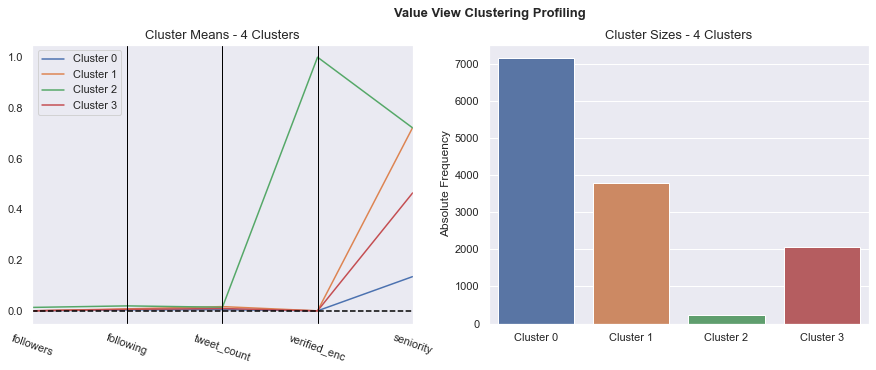

In [225]:
val_concat_scaled_2021 = pd.concat((value_scaled_2021, pd.Series(hc_val_labels, name='labels')), axis=1)
cluster_profiles(df=val_concat_scaled_2021, label_columns=['labels'], figsize=(15, 5),
                 compar_titles=['Value View Clustering Profiling'])

### Preference view - 2020

In [226]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(n_clusters=4, linkage=linkage, affinity=distance)
hc_pref_labels = hclust.fit_predict(pref_scaled)

pref_concat = pd.concat((pref, pd.Series(hc_pref_labels, name='labels')), axis=1)
pref_concat.groupby('labels').mean()

,like_count,retweet_count,quote_count,reach,sentiment_enc,day_phase_enc,day_of_week_enc,month_enc
labels,,,,,,,,
0,4.663634,0.598402,0.096960,4689.312181,0.516086,1.0,1.000000,7.949634
1,26.430962,3.678661,0.260251,6944.878940,1.999721,1.0,1.000000,7.446304
2,8.630390,1.254327,0.114696,8864.156351,0.732180,1.0,1.366676,2.231446
3,6.514580,1.116066,0.082333,4415.924528,2.000000,1.0,1.000000,1.497427


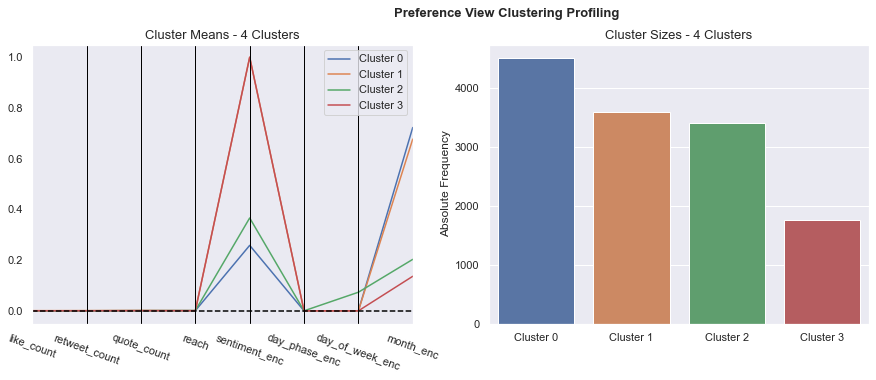

In [227]:
pref_concat_scaled = pd.concat((pref_scaled, pd.Series(hc_pref_labels, name='labels')), axis=1)
cluster_profiles(df=pref_concat_scaled, label_columns=['labels'], figsize=(15, 5),
                 compar_titles=['Preference View Clustering Profiling'])

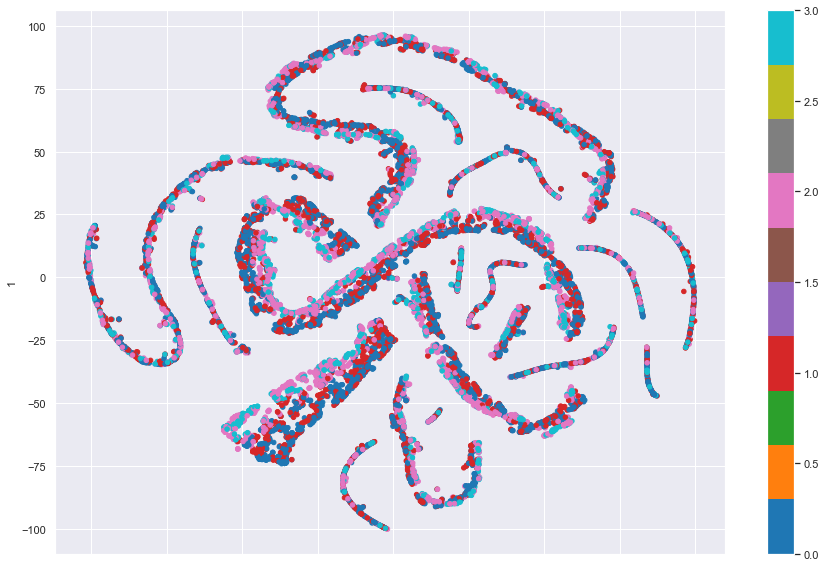

In [228]:
two_dim = TSNE(random_state=42).fit_transform(pref_concat.drop(columns=['labels']))

pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=pref_concat['labels'], colormap='tab10', figsize=(15, 10))
plt.show()

In [229]:
sst = get_ss(pref)
ssw_labels = pref_concat.groupby(by='labels').apply(get_ss)
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

0.0002921504462549666

### Preference view - 2021

In [230]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(n_clusters=4, linkage=linkage, affinity=distance)
hc_pref_labels = hclust.fit_predict(pref_scaled_2021)

pref_concat_2021 = pd.concat((pref_2021, pd.Series(hc_pref_labels, name='labels')), axis=1)
pref_concat_2021.groupby('labels').mean()

,like_count,retweet_count,quote_count,reach,sentiment_enc,day_phase_enc,day_of_week_enc,month_enc
labels,,,,,,,,
0,14.461192,1.969983,0.563679,10093.831904,1.568825,1.0,0.946398,2.330832
1,8.939474,1.063816,0.161184,13138.561842,0.000000,1.0,1.000000,5.488816
2,5.197264,0.717783,0.136069,3296.506479,1.000000,1.0,1.000000,8.024478
3,11.162572,1.093569,0.114162,5119.960983,2.000000,1.0,1.000000,8.454118


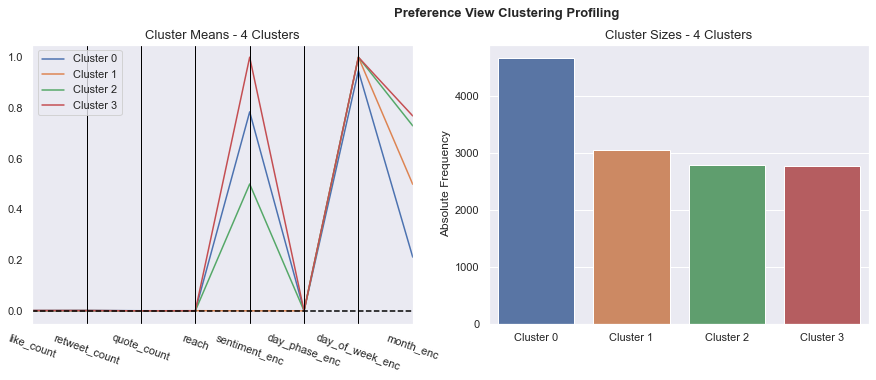

In [231]:
pref_concat_scaled_2021 = pd.concat((pref_scaled_2021, pd.Series(hc_pref_labels, name='labels')), axis=1)
cluster_profiles(df=pref_concat_scaled_2021, label_columns=['labels'], figsize=(15, 5),
                 compar_titles=['Preference View Clustering Profiling'])

### Joining clusters 2020

In [232]:
joined_clusters_scaled = pd.concat([val_concat_scaled, pref_concat_scaled], axis=1)
joined_clusters = pd.concat([val_concat, pref_concat], axis=1)
joined_clusters_scaled['value_labels'] = val_concat_scaled['labels']
joined_clusters_scaled['pref_labels'] = pref_concat_scaled['labels']

joined_clusters['value_labels'] = val_concat['labels']
joined_clusters['pref_labels'] = pref_concat['labels']
joined_clusters = joined_clusters.drop(['labels', 'labels'], axis=1)
joined_clusters_scaled = joined_clusters_scaled.drop(['labels', 'labels'], axis=1)
joined_clusters_scaled.groupby(['value_labels', 'pref_labels'])['value_labels'].count().count()
df_centroids = joined_clusters_scaled.groupby(['value_labels', 'pref_labels']).mean()
df_centroids

followers  following  tweet_count  verified_enc  \
value_labels pref_labels                                                    
0            0             0.000368   0.003023     0.001740           0.0   
             1             0.000339   0.003727     0.001416           0.0   
             2             0.000386   0.003834     0.001786           0.0   
             3             0.000381   0.003729     0.001279           0.0   
1            0             0.000214   0.002455     0.001359           0.0   
             1             0.000229   0.002908     0.001097           0.0   
             2             0.000213   0.002009     0.002095           0.0   
             3             0.000306   0.003429     0.000797           0.0   
2            0             0.015563   0.006599     0.001855           1.0   
             1             0.022177   0.006971     0.001683           1.0   
             2             0.044568   0.008610     0.002741           1.0   
             3             0.009504   0.016111     0.003010           1.0   
3            0             0.000142   0.001738     0.000483           0.0   
             1             0.000260   0.001607     0.000415           0.0   
             2             0.000238   0.001405     0.000441           0.0   
             3             0.000140   0.001792     0.000466           0.0   

                          seniority  like_count  retweet_count  quote_count  \
value_labels pref_labels                                                      
0            0             0.672902    0.000074       0.000117     0.000454   
             1             0.673159    0.000150       0.000234     0.000607   
             2             0.667068    0.000247       0.000292     0.000537   
             3             0.670482    0.000089       0.000149     0.000319   
1            0             0.316439    0.000194       0.000192     0.000450   
             1             0.313668    0.000556       0.001316     0.001461   
             2             0.320025    0.000264       0.000450     0.000526   
             3             0.314061    0.000134       0.000259     0.000374   
2            0             0.712585    0.001591       0.001534     0.008598   
             1             0.720100    0.020309       0.018942     0.022682   
             2             0.715539    0.001460       0.001954     0.006173   
             3             0.671096    0.001681       0.001390     0.002153   
3            0             0.074527    0.000081       0.000117     0.000431   
             1             0.075226    0.000259       0.000386     0.001505   
             2             0.078932    0.000172       0.000221     0.000823   
             3             0.072136    0.000261       0.000486     0.000770   

                             reach  sentiment_enc  day_phase_enc  \
value_labels pref_labels                                           
0            0            0.000368       0.254131            0.0   
             1            0.000339       1.000000            0.0   
             2            0.000386       0.365903            0.0   
             3            0.000381       1.000000            0.0   
1            0            0.000214       0.248518            0.0   
             1            0.000229       1.000000            0.0   
             2            0.000213       0.376092            0.0   
             3            0.000306       1.000000            0.0   
2            0            0.015563       0.244048            0.0   
             1            0.022177       0.994186            0.0   
             2            0.044568       0.342105            0.0   
             3            0.009504       1.000000            0.0   
3            0            0.000142       0.274297            0.0   
             1            0.000260       1.000000            0.0   
             2            0.000238       0.358193            0.0   
             3            0.000140       1.000000           

#### Analizing joint performance - 2020

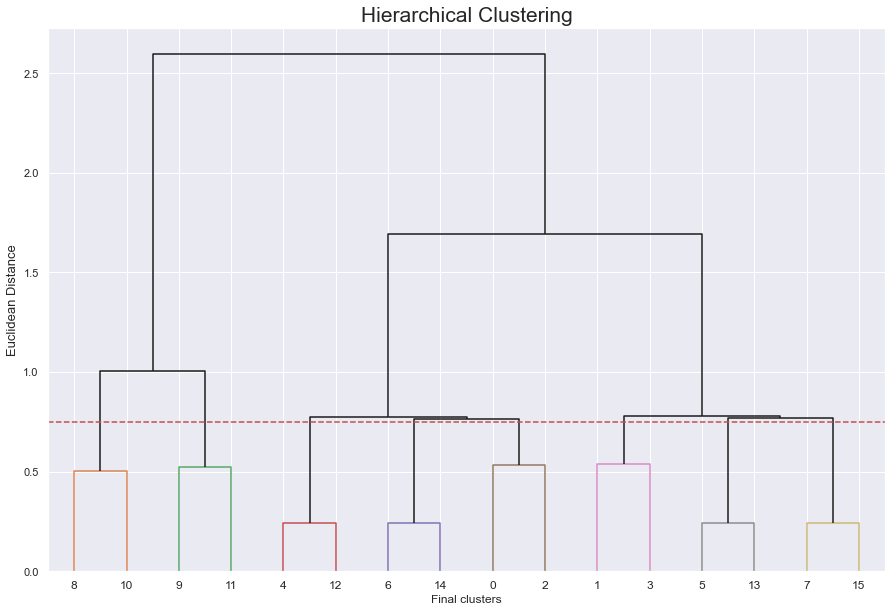

In [233]:
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', distance_threshold=0, n_clusters=None)
hclust_labels = hclust.fit_predict(df_centroids)

df_centroids['hclust_labels'] = hclust_labels
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together # At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
            counts[i] = current_count

linkage_matrix = np.column_stack([hclust.children_, hclust.distances_, counts]).astype(float)
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(15, 10))
# The Dendrogram parameters need to be tuned
y_threshold = 0.75
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering', fontsize=21)
plt.xlabel('Final clusters')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

### Joining clusters 2021

In [234]:
joined_clusters_scaled_2021 = pd.concat([val_concat_scaled_2021, pref_concat_scaled_2021], axis=1)
joined_clusters_2021 = pd.concat([val_concat_2021, pref_concat_2021], axis=1)
joined_clusters_scaled_2021['value_labels'] = val_concat_scaled_2021['labels']
joined_clusters_scaled_2021['pref_labels'] = pref_concat_scaled_2021['labels']

joined_clusters_2021['value_labels'] = val_concat_2021['labels']
joined_clusters_2021['pref_labels'] = pref_concat_2021['labels']
joined_clusters_2021 = joined_clusters_2021.drop(['labels', 'labels'], axis=1)
joined_clusters_scaled_2021 = joined_clusters_scaled_2021.drop(['labels', 'labels'], axis=1)
joined_clusters_scaled_2021.groupby(['value_labels', 'pref_labels'])['value_labels'].count().count()
df_centroids_2021 = joined_clusters_scaled_2021.groupby(['value_labels', 'pref_labels']).mean()
df_centroids_2021

followers  following  tweet_count  verified_enc  \
value_labels pref_labels                                                    
0            0             0.000066   0.003931     0.004667           0.0   
             1             0.000047   0.003819     0.004612           0.0   
             2             0.000044   0.003578     0.005457           0.0   
             3             0.000065   0.003702     0.004810           0.0   
1            0             0.000137   0.006941     0.017779           0.0   
             1             0.000144   0.009445     0.015269           0.0   
             2             0.000086   0.006476     0.019966           0.0   
             3             0.000105   0.008391     0.013123           0.0   
2            0             0.016028   0.027749     0.014558           1.0   
             1             0.024498   0.017004     0.011471           1.0   
             2             0.004984   0.007567     0.011623           1.0   
             3             0.004963   0.017317     0.017603           1.0   
3            0             0.000162   0.005083     0.009080           0.0   
             1             0.000081   0.005924     0.009196           0.0   
             2             0.000078   0.004809     0.009396           0.0   
             3             0.000186   0.007955     0.008882           0.0   

                          seniority  like_count  retweet_count  quote_count  \
value_labels pref_labels                                                      
0            0             0.140427    0.001314       0.001987     0.000613   
             1             0.134717    0.000667       0.000926     0.000086   
             2             0.131742    0.000523       0.000656     0.000119   
             3             0.129420    0.001061       0.000909     0.000065   
1            0             0.723333    0.000280       0.000319     0.000041   
             1             0.721979    0.000526       0.000440     0.000054   
             2             0.722047    0.000246       0.000349     0.000037   
             3             0.722785    0.000618       0.000597     0.000076   
2            0             0.755285    0.014339       0.018404     0.002622   
             1             0.682051    0.013957       0.010795     0.002476   
             2             0.705556    0.004357       0.004215     0.001044   
             3             0.717857    0.007578       0.005049     0.000572   
3            0             0.463428    0.001682       0.001007     0.000050   
             1             0.466805    0.000347       0.000459     0.000049   
             2             0.465426    0.000332       0.000507     0.000031   
             3             0.464775    0.000647       0.000927     0.000074   

                             reach  sentiment_enc  day_phase_enc  \
value_labels pref_labels                                           
0            0            0.000066       0.788996            0.0   
             1            0.000047       0.000000            0.0   
             2            0.000044       0.500000            0.0   
             3            0.000065       1.000000            0.0   
1            0            0.000137       0.787132            0.0   
             1            0.000144       0.000000            0.0   
             2            0.000086       0.500000            0.0   
             3            0.000105       1.000000            0.0   
2            0            0.016028       0.786585            0.0   
             1            0.024498       0.000000            0.0   
             2            0.004984       0.500000            0.0   
             3            0.004963       1.000000            0.0   
3            0            0.000162       0.763833            0.0   
             1            0.000081       0.000000            0.0   
             2            0.000078       0.500000            0.0   
             3            0.000186       1.000000           

### Solution with 6 clusters (final solution) for 2020

In [235]:
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=6)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels
cluster_mapper = df_centroids['hclust_labels'].to_dict()
joined_clusters['merged_labels'] = joined_clusters.apply(lambda row: cluster_mapper[(row['value_labels'], row['pref_labels'])], axis=1)
joined_clusters_scaled['merged_labels'] = joined_clusters_scaled.apply(lambda row: cluster_mapper[(row['value_labels'], row['pref_labels'])], axis=1)
sol_clusters = joined_clusters.drop(columns=['value_labels', 'pref_labels', 'merged_labels'], axis=1)
sol_clusters

,followers,following,tweet_count,verified_enc,seniority,like_count,retweet_count,quote_count,reach,sentiment_enc,day_phase_enc,day_of_week_enc,month_enc
0,100,390,3961,0,3,0,0,0,100,2,1,6,4
1,257,1028,4807,0,11,0,0,0,257,1,1,6,4
2,575,1316,69233,0,10,1,1,0,575,1,1,6,4
3,1425,515,307238,0,9,1,0,1,1425,2,1,6,4
4,729,231,12946,0,8,1,0,0,729,1,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13245,17,1,224524,0,12,0,0,0,17,1,1,1,2
13246,399,356,14608,0,1,0,0,1,399,2,1,1,2
13247,87948,12,76251,0,6,224,43,2,87948,0,1,1,2
13248,51,18,63867,0,8,0,0,0,51,2,1,1,2


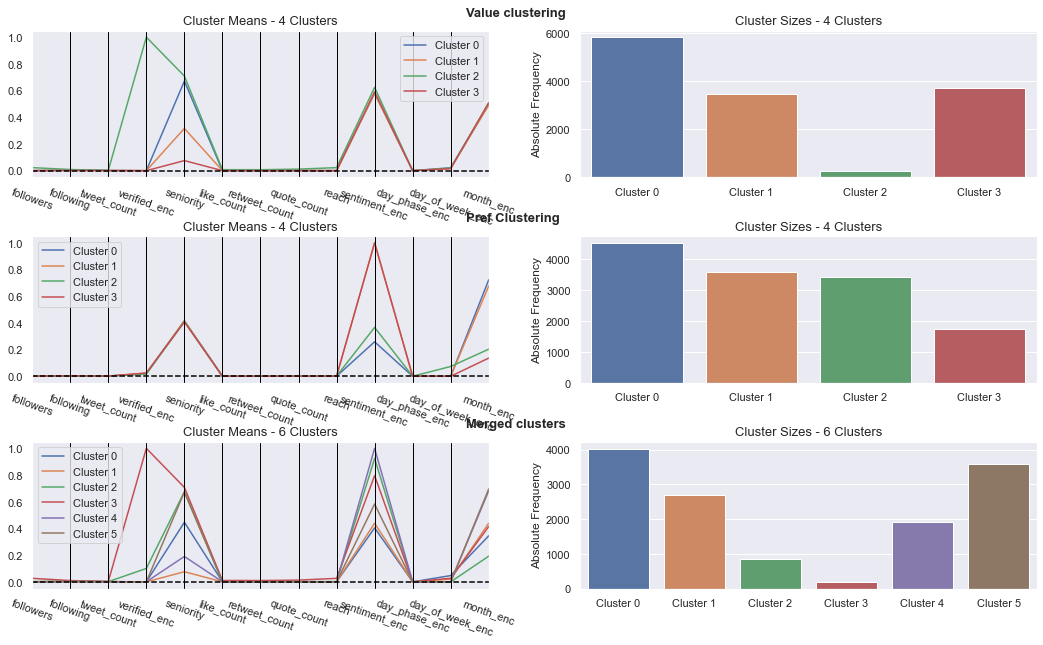

In [236]:
cluster_profiles(df=joined_clusters_scaled, label_columns=['value_labels', 'pref_labels', 'merged_labels'], figsize=(18, 10), compar_titles=['Value clustering', 'Pref Clustering', "Merged clusters"])

In [237]:
cluster6_scaled_final = joined_clusters_scaled.drop(columns=['value_labels', 'pref_labels'])
cluster6_final = joined_clusters.drop(columns=['value_labels', 'pref_labels'])
cluster6_scaled_final

,followers,following,tweet_count,verified_enc,seniority,like_count,retweet_count,quote_count,reach,sentiment_enc,day_phase_enc,day_of_week_enc,month_enc,merged_labels
0,0.000012,0.000888,0.000085,0.0,0.142857,0.000000,0.000000,0.000000,0.000012,1.0,0.0,1.0,0.363636,1
1,0.000030,0.002342,0.000103,0.0,0.714286,0.000000,0.000000,0.000000,0.000030,0.5,0.0,1.0,0.363636,0
2,0.000067,0.002998,0.001490,0.0,0.642857,0.000029,0.000273,0.000000,0.000067,0.5,0.0,1.0,0.363636,0
3,0.000167,0.001173,0.006610,0.0,0.571429,0.000029,0.000000,0.006173,0.000167,1.0,0.0,1.0,0.363636,0
4,0.000085,0.000526,0.000279,0.0,0.500000,0.000029,0.000000,0.000000,0.000085,0.5,0.0,1.0,0.363636,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13245,0.000002,0.000002,0.004831,0.0,0.785714,0.000000,0.000000,0.000000,0.000002,0.5,0.0,0.0,0.181818,0
13246,0.000047,0.000811,0.000314,0.0,0.000000,0.000000,0.000000,0.006173,0.000047,1.0,0.0,0.0,0.181818,1
13247,0.010286,0.000027,0.001641,0.0,0.357143,0.006515,0.011739,0.012346,0.010286,0.0,0.0,0.0,0.181818,0
13248,0.000006,0.000041,0.001374,0.0,0.500000,0.000000,0.000000,0.000000,0.000006,1.0,0.0,0.0,0.181818,2


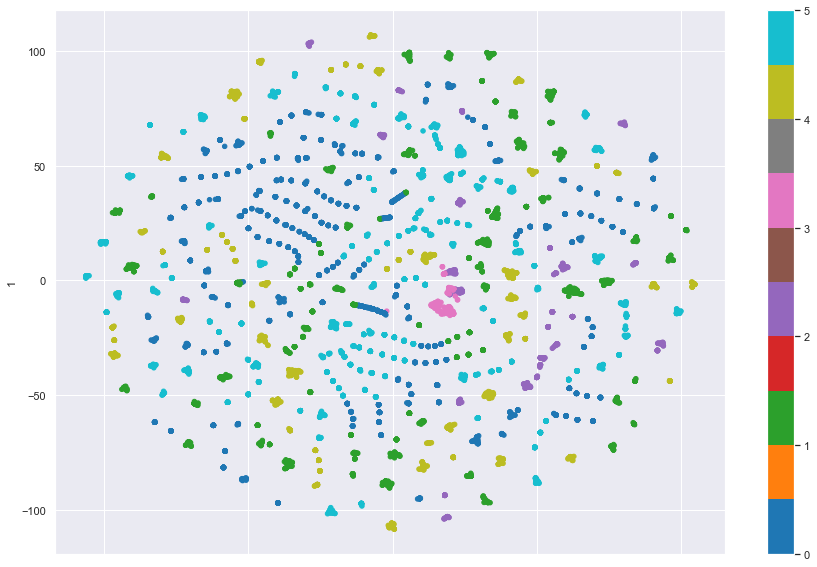

In [238]:
two_dim = TSNE(random_state=42).fit_transform(cluster6_scaled_final.drop(columns=['merged_labels']))

pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=cluster6_scaled_final['merged_labels'], colormap='tab10', figsize=(15, 10))
plt.show()

In [239]:
pd.Series(cluster6_scaled_final.merged_labels).value_counts()

0    4027
5    3574
1    2702
4    1922
2     839
3     186
Name: merged_labels, dtype: int64

In [240]:
sst = get_ss(sol_clusters)
ssw_labels = cluster6_final.groupby(by='merged_labels').apply(get_ss)
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2
cluster6_final.groupby('merged_labels').mean()

,followers,following,tweet_count,verified_enc,seniority,like_count,retweet_count,quote_count,reach,sentiment_enc,day_phase_enc,day_of_week_enc,month_enc
merged_labels,,,,,,,,,,,,,
0,2455.494413,1303.538118,75359.903650,0.000000,7.246834,7.659051,1.080457,0.079464,2455.494413,0.808046,1.0,1.234666,3.792401
1,1500.457069,715.908586,21618.755736,0.000000,2.058845,5.044041,0.816432,0.102517,1500.457069,0.878979,1.0,1.103627,4.831606
2,16251.017878,1763.302741,62113.257449,0.100119,10.445769,8.239571,1.052443,0.185936,16251.017878,1.848629,1.0,1.000000,2.116806
3,223230.376344,4208.338710,107540.790323,1.000000,10.903226,351.618280,35.451613,2.086022,223230.376344,1.591398,1.0,1.134409,4.564516
4,2093.445890,980.416233,34541.374610,0.000000,3.659729,13.825182,3.052549,0.240375,2093.445890,2.000000,1.0,1.000000,7.508845
5,3036.349748,1463.548125,74211.998041,0.000000,10.422216,3.702015,0.618914,0.084499,3036.349748,1.166480,1.0,1.000000,7.656967


### Solution with 12 clusters (final solution) for 2020

In [241]:
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=12)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels
cluster_mapper = df_centroids['hclust_labels'].to_dict()
joined_clusters['merged_labels'] = joined_clusters.apply(lambda row: cluster_mapper[(row['value_labels'], row['pref_labels'])], axis=1)
joined_clusters_scaled['merged_labels'] = joined_clusters_scaled.apply(lambda row: cluster_mapper[(row['value_labels'], row['pref_labels'])], axis=1)
sol_clusters = joined_clusters.drop(columns=['value_labels', 'pref_labels', 'merged_labels'], axis=1)
sol_clusters

,followers,following,tweet_count,verified_enc,seniority,like_count,retweet_count,quote_count,reach,sentiment_enc,day_phase_enc,day_of_week_enc,month_enc
0,100,390,3961,0,3,0,0,0,100,2,1,6,4
1,257,1028,4807,0,11,0,0,0,257,1,1,6,4
2,575,1316,69233,0,10,1,1,0,575,1,1,6,4
3,1425,515,307238,0,9,1,0,1,1425,2,1,6,4
4,729,231,12946,0,8,1,0,0,729,1,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13245,17,1,224524,0,12,0,0,0,17,1,1,1,2
13246,399,356,14608,0,1,0,0,1,399,2,1,1,2
13247,87948,12,76251,0,6,224,43,2,87948,0,1,1,2
13248,51,18,63867,0,8,0,0,0,51,2,1,1,2


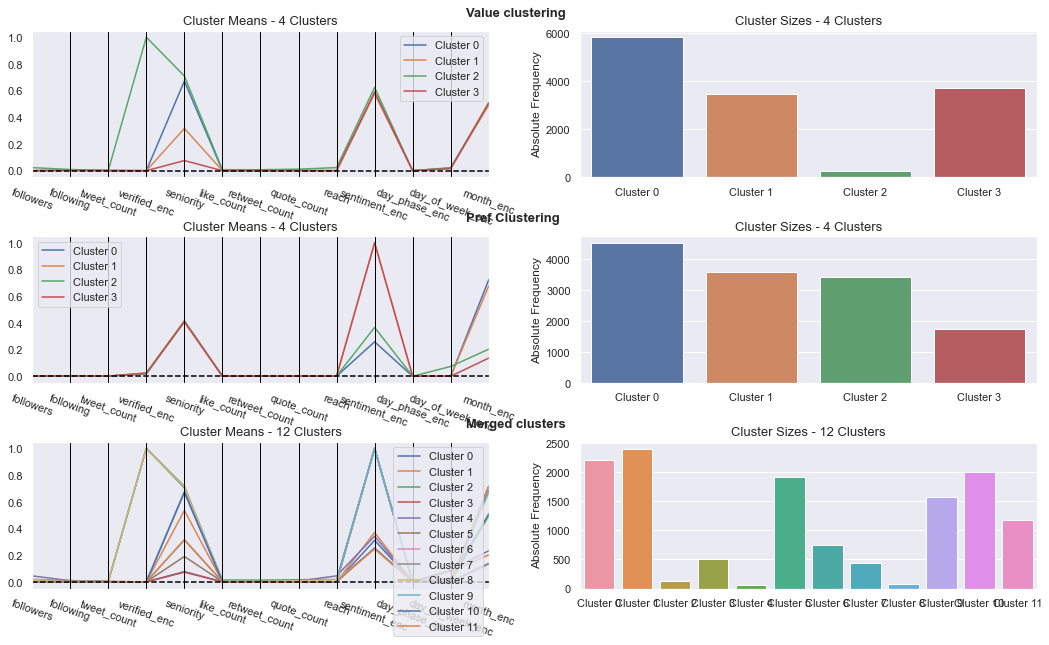

In [242]:
cluster_profiles(df=joined_clusters_scaled, label_columns=['value_labels', 'pref_labels', 'merged_labels'], figsize=(18, 10), compar_titles=['Value clustering', 'Pref Clustering', "Merged clusters"])

In [243]:
cluster12_scaled_final = joined_clusters_scaled.drop(columns=['value_labels', 'pref_labels'])
cluster12_final = joined_clusters.drop(columns=['value_labels', 'pref_labels'])
cluster12_scaled_final

,followers,following,tweet_count,verified_enc,seniority,like_count,retweet_count,quote_count,reach,sentiment_enc,day_phase_enc,day_of_week_enc,month_enc,merged_labels
0,0.000012,0.000888,0.000085,0.0,0.142857,0.000000,0.000000,0.000000,0.000012,1.0,0.0,1.0,0.363636,0
1,0.000030,0.002342,0.000103,0.0,0.714286,0.000000,0.000000,0.000000,0.000030,0.5,0.0,1.0,0.363636,1
2,0.000067,0.002998,0.001490,0.0,0.642857,0.000029,0.000273,0.000000,0.000067,0.5,0.0,1.0,0.363636,1
3,0.000167,0.001173,0.006610,0.0,0.571429,0.000029,0.000000,0.006173,0.000167,1.0,0.0,1.0,0.363636,1
4,0.000085,0.000526,0.000279,0.0,0.500000,0.000029,0.000000,0.000000,0.000085,0.5,0.0,1.0,0.363636,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13245,0.000002,0.000002,0.004831,0.0,0.785714,0.000000,0.000000,0.000000,0.000002,0.5,0.0,0.0,0.181818,1
13246,0.000047,0.000811,0.000314,0.0,0.000000,0.000000,0.000000,0.006173,0.000047,1.0,0.0,0.0,0.181818,3
13247,0.010286,0.000027,0.001641,0.0,0.357143,0.006515,0.011739,0.012346,0.010286,0.0,0.0,0.0,0.181818,1
13248,0.000006,0.000041,0.001374,0.0,0.500000,0.000000,0.000000,0.000000,0.000006,1.0,0.0,0.0,0.181818,6


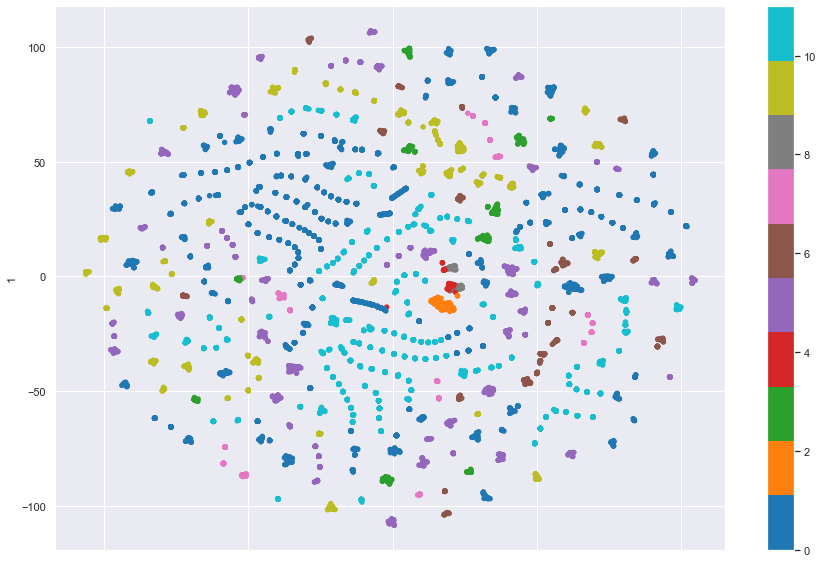

In [244]:
two_dim = TSNE(random_state=42).fit_transform(cluster12_scaled_final.drop(columns=['merged_labels']))

pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=cluster12_scaled_final['merged_labels'], colormap='tab10', figsize=(15, 10))
plt.show()

In [245]:
pd.Series(cluster12_scaled_final.merged_labels).value_counts()

1     2400
0     2197
10    1997
5     1922
9     1577
11    1181
6      755
3      505
7      446
2      129
8       84
4       57
Name: merged_labels, dtype: int64

In [246]:
sst = get_ss(sol_clusters)
ssw_labels = cluster12_final.groupby(by='merged_labels').apply(get_ss)
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

0.012300932765497314

In [247]:
cluster12_final.groupby('merged_labels').mean()

,followers,following,tweet_count,verified_enc,seniority,like_count,retweet_count,quote_count,reach,sentiment_enc,day_phase_enc,day_of_week_enc,month_enc
merged_labels,,,,,,,,,,,,,
0,1569.581247,699.656350,21607.448339,0.0,2.070096,4.138371,0.594902,0.097406,1569.581247,0.621302,1.0,1.127447,5.592171
1,2733.063750,1377.153333,88485.383750,0.0,8.484583,8.720833,1.290000,0.086250,2733.063750,0.739583,1.0,1.393750,2.215417
2,153492.472868,4397.643411,98767.139535,1.0,10.852713,484.798450,47.953488,2.565891,153492.472868,1.992248,1.0,1.000000,5.449612
3,1199.732673,786.613861,21667.948515,0.0,2.009901,8.984158,1.780198,0.124752,1199.732673,2.000000,1.0,1.000000,1.522772
4,381058.263158,3779.912281,127396.947368,1.0,11.017544,50.210526,7.157895,1.000000,381058.263158,0.684211,1.0,1.438596,2.561404
5,2093.445890,980.416233,34541.374610,0.0,3.659729,13.825182,3.052549,0.240375,2093.445890,2.000000,1.0,1.000000,7.508845
6,3254.271523,1637.196026,59433.607947,0.0,10.386755,3.071523,0.544371,0.051656,3254.271523,2.000000,1.0,1.000000,1.476821
7,2615.376682,1505.125561,37038.114350,0.0,5.396861,4.603139,0.948430,0.060538,2615.376682,2.000000,1.0,1.000000,1.491031
8,133067.011905,2896.761905,86198.202381,1.0,10.976190,54.690476,5.619048,1.392857,133067.011905,0.488095,1.0,1.000000,7.869048


### Solution with 6 clusters (final solution) for 2021

In [248]:
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=6)
hclust_labels = hclust.fit_predict(df_centroids_2021)
df_centroids_2021['hclust_labels'] = hclust_labels
cluster_mapper_2021 = df_centroids_2021['hclust_labels'].to_dict()
joined_clusters_2021['merged_labels'] = joined_clusters_2021.apply(lambda row: cluster_mapper_2021[(row['value_labels'], row['pref_labels'])], axis=1)
joined_clusters_scaled_2021['merged_labels'] = joined_clusters_scaled_2021.apply(lambda row: cluster_mapper_2021[(row['value_labels'], row['pref_labels'])], axis=1)
sol_clusters_2021 = joined_clusters_2021.drop(columns=['value_labels', 'pref_labels', 'merged_labels'], axis=1)
sol_clusters_2021

,followers,following,tweet_count,verified_enc,seniority,like_count,retweet_count,quote_count,reach,sentiment_enc,day_phase_enc,day_of_week_enc,month_enc
0,1047,849,7153,0,5,0,0,0,1047,0,1,1,4
1,188,261,1496,0,1,3,0,0,188,0,1,1,4
2,1805,1709,3198,0,8,0,0,0,1805,2,1,1,4
3,1564,1620,44863,0,7,0,0,0,1564,1,1,1,4
4,538,1239,11288,0,13,2,0,0,538,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13245,269,419,14065,0,10,3,0,0,269,2,1,0,4
13246,3933,608,29138,0,6,13,0,1,3933,2,1,0,4
13247,8398,364,885594,0,12,0,0,0,8398,2,1,0,4
13248,8125,882,15081,0,6,12,1,0,8125,2,1,0,4


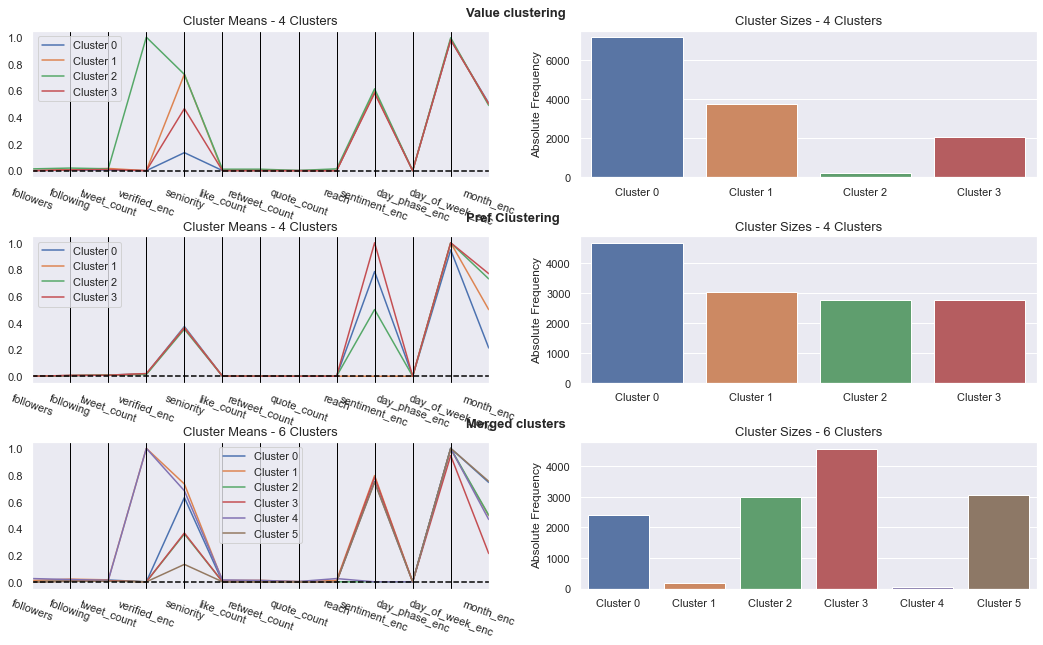

In [249]:
cluster_profiles(df=joined_clusters_scaled_2021, label_columns=['value_labels', 'pref_labels', 'merged_labels'], figsize=(18, 10), compar_titles=['Value clustering', 'Pref Clustering', "Merged clusters"])

In [250]:
cluster6_scaled_final_2021 = joined_clusters_scaled_2021.drop(columns=['value_labels', 'pref_labels'])
cluster6_final_2021 = joined_clusters_2021.drop(columns=['value_labels', 'pref_labels'])
cluster6_scaled_final_2021

,followers,following,tweet_count,verified_enc,seniority,like_count,retweet_count,quote_count,reach,sentiment_enc,day_phase_enc,day_of_week_enc,month_enc,merged_labels
0,0.000040,0.004093,0.001323,0.0,0.333333,0.000000,0.000000,0.000000,0.000040,0.0,0.0,1.0,0.363636,2
1,0.000007,0.001258,0.000277,0.0,0.066667,0.000270,0.000000,0.000000,0.000007,0.0,0.0,1.0,0.363636,2
2,0.000068,0.008240,0.000591,0.0,0.533333,0.000000,0.000000,0.000000,0.000068,1.0,0.0,1.0,0.363636,3
3,0.000059,0.007811,0.008297,0.0,0.466667,0.000000,0.000000,0.000000,0.000059,0.5,0.0,1.0,0.363636,3
4,0.000020,0.005974,0.002088,0.0,0.866667,0.000180,0.000000,0.000000,0.000020,0.0,0.0,1.0,0.363636,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13245,0.000010,0.002020,0.002601,0.0,0.666667,0.000270,0.000000,0.000000,0.000010,1.0,0.0,0.0,0.363636,3
13246,0.000149,0.002931,0.005389,0.0,0.400000,0.001169,0.000000,0.000696,0.000149,1.0,0.0,0.0,0.363636,3
13247,0.000318,0.001755,0.163784,0.0,0.800000,0.000000,0.000000,0.000000,0.000318,1.0,0.0,0.0,0.363636,3
13248,0.000308,0.004253,0.002789,0.0,0.400000,0.001079,0.000829,0.000000,0.000308,1.0,0.0,0.0,0.363636,3


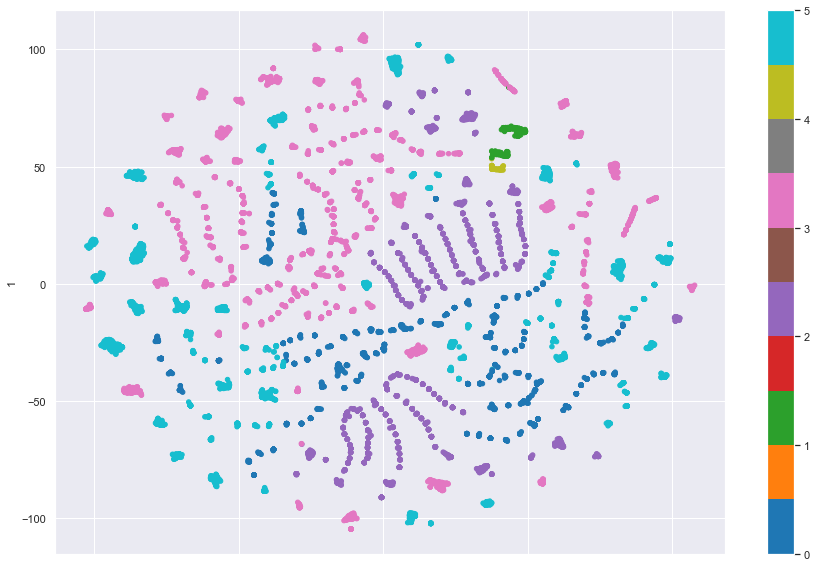

In [251]:
two_dim = TSNE(random_state=42).fit_transform(cluster6_scaled_final_2021.drop(columns=['merged_labels']))
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=cluster6_scaled_final_2021['merged_labels'], colormap='tab10',
                                   figsize=(15, 10))
plt.show()

In [252]:
pd.Series(cluster6_scaled_final_2021.merged_labels).value_counts()

3    4582
5    3049
2    2988
0    2405
1     174
4      52
Name: merged_labels, dtype: int64

In [253]:
sst = get_ss(sol_clusters_2021)
ssw_labels = cluster6_final.groupby(by='merged_labels').apply(get_ss)
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

-0.17479073486637947

In [254]:
cluster6_final_2021.groupby('merged_labels').mean()

,followers,following,tweet_count,verified_enc,seniority,like_count,retweet_count,quote_count,reach,sentiment_enc,day_phase_enc,day_of_week_enc,month_enc
merged_labels,,,,,,,,,,,,,
0,2860.903534,1465.757588,75042.469439,0.0,9.467360,5.052807,0.676091,0.079418,2860.903534,1.504366,1.0,1.000000,8.187942
1,268574.683908,4192.913793,80732.379310,1.0,10.994253,112.339080,13.471264,2.350575,268574.683908,1.591954,1.0,0.994253,5.442529
2,2121.193440,1201.633869,45686.592035,0.0,5.384538,6.392905,0.855756,0.102075,2121.193440,0.000000,1.0,1.000000,5.494980
3,2708.147970,1039.324749,50136.344391,0.0,5.485159,11.865124,1.608031,0.506329,2708.147970,1.568747,1.0,0.945657,2.330860
4,646213.500000,3526.711538,62025.942308,1.0,10.230769,155.269231,13.019231,3.557692,646213.500000,0.000000,1.0,1.000000,5.134615
5,1438.562480,754.712365,27788.720892,0.0,1.959003,8.762873,0.941620,0.132174,1438.562480,1.491637,1.0,1.000000,8.279764


# Machine Learning

### Predicting tweet popularity in 2021 using 2020 data

## Data spliting

In [255]:
num_folds = 10
seed = 7
scoring = 'accuracy'
validation_size = 0.70

In [256]:
inputs = df_2020[tweet_vars + users_vars]
inputs.columns

Index(['like_count', 'retweet_count', 'quote_count', 'reach', 'sentiment_enc',
       'day_phase_enc', 'day_of_week_enc', 'month_enc', 'followers',
       'following', 'tweet_count', 'verified_enc', 'seniority'],
      dtype='object')

In [257]:
targets = df_2020['popularity']
X_train, X_validation, y_train, y_validation = train_test_split(inputs, targets, test_size=validation_size, random_state=seed, shuffle=False)

#### Partition of numeric and categorical datasets

In [258]:
X_train_num = X_train[num_vars].set_index(X_train.index)
X_train_cat = X_train[cat_vars].set_index(X_train.index)

X_val_num = X_validation[num_vars].set_index(X_validation.index)
X_val_cat = X_validation[cat_vars].set_index(X_validation.index)

## Standardization

In [259]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled , columns = X_train.columns)

X_val_scaled = scaler.fit_transform(X_validation)
X_val_scaled = pd.DataFrame(X_val_scaled , columns = X_validation.columns)

In [260]:
scaler = StandardScaler().fit(X_train_num)
X_train_num_scaled = scaler.transform(X_train_num)
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_num.columns).set_index(X_train.index)

X_val_num_scaled = scaler.transform(X_val_num)
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val_num.columns).set_index(X_validation.index)

## Feature Selection

### Univariate variables

In [261]:
X_train_num_scaled.var()

like_count       1.000006
retweet_count    1.000006
quote_count      1.000006
reach            1.000006
followers        1.000006
following        1.000006
tweet_count      1.000006
seniority        1.000006
dtype: float64

In [262]:
num_feat_to_keep = pd.DataFrame(index=X_train_num_scaled.columns)
num_feat_to_keep

""
like_count
retweet_count
quote_count
reach
followers
following
tweet_count
seniority


### Recursive Feature Elimination - RFE

In [263]:
#no of features
nof_list = np.arange(1, 9)
high_score = 0
#Variable to store the optimum features
nof = 0
score_list = []
for n in range(len(nof_list)):
    model = LogisticRegression()
    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_num_scaled, y_train)
    X_val_rfe = rfe.transform(X_val_num_scaled)
    model.fit(X_train_rfe, y_train)

    score = model.score(X_val_rfe, y_validation)
    score_list.append(score)

    if score > high_score:
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" % nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 6
Score with 6 features: 0.909839


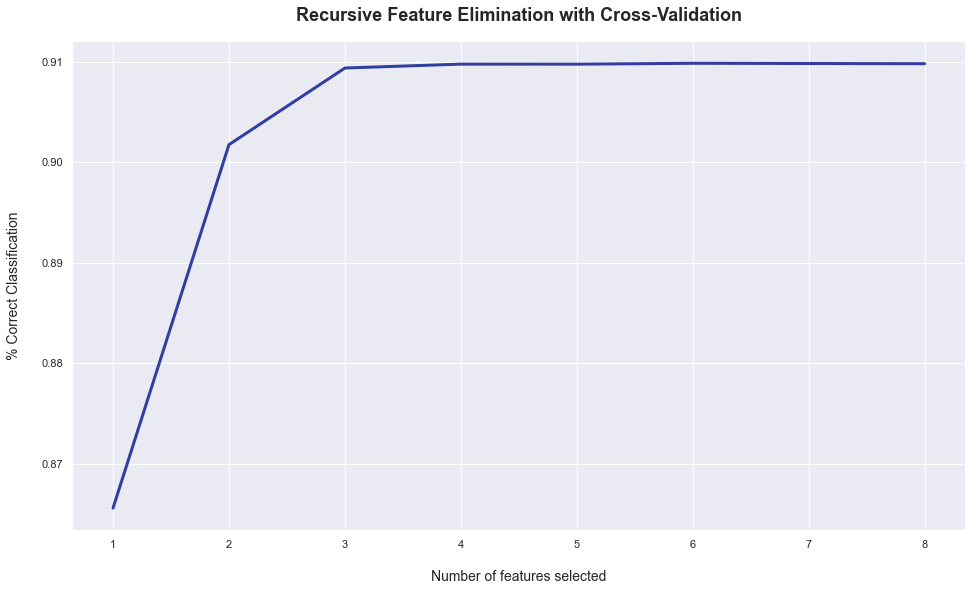

In [264]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(score_list) + 1), score_list, color='#303F9F', linewidth=3)
plt.show()

In [265]:
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=5)
X_rfe = rfe.fit_transform(X=X_train_num_scaled, y=y_train)
selected_features = pd.Series(rfe.support_, index=X_train_num_scaled.columns)
selected_features[selected_features == True]

like_count       True
retweet_count    True
quote_count      True
reach            True
followers        True
dtype: bool

In [266]:
num_feat_to_keep['RFE'] = 'Discard'

for var in selected_features[selected_features == True].index:
    num_feat_to_keep.loc[var, 'RFE'] = 'Keep'

### LASSO Regression

In [267]:
def plot_importance(coef, name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8, 10))
    imp_coef.plot(kind="barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [268]:
reg = LassoCV()
reg.fit(X_train_num_scaled, y_train)
coef = pd.Series(reg.coef_,
                 index=X_train_num_scaled.columns)  #Check the coefficients associated with each of the variables
coef

like_count       3.890239e-03
retweet_count    0.000000e+00
quote_count      9.762691e-03
reach            2.075245e-02
followers        8.885983e-16
following        2.088610e-02
tweet_count     -0.000000e+00
seniority        0.000000e+00
dtype: float64

In [269]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef == 0)) + " variables")

Lasso picked 5 variables and eliminated the other 3 variables


In [270]:
coef.sort_values()

retweet_count    0.000000e+00
tweet_count     -0.000000e+00
seniority        0.000000e+00
followers        8.885983e-16
like_count       3.890239e-03
quote_count      9.762691e-03
reach            2.075245e-02
following        2.088610e-02
dtype: float64

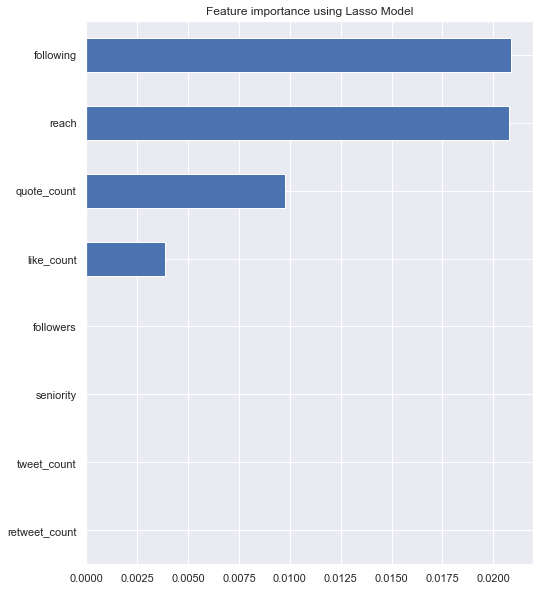

In [271]:
plot_importance(coef,'Lasso')

### Chi-square

In [272]:
chi_scores = chi2(X_train[cat_vars], y_train)
chi_scores

(array([1.07269243e+02, 5.26908289e+03, 1.49368537e-02, 9.21540778e-01,
        8.07244088e-01]),
 array([3.88618830e-25, 0.00000000e+00, 9.02727621e-01, 3.37070739e-01,
        3.68936293e-01]))

<AxesSubplot:>

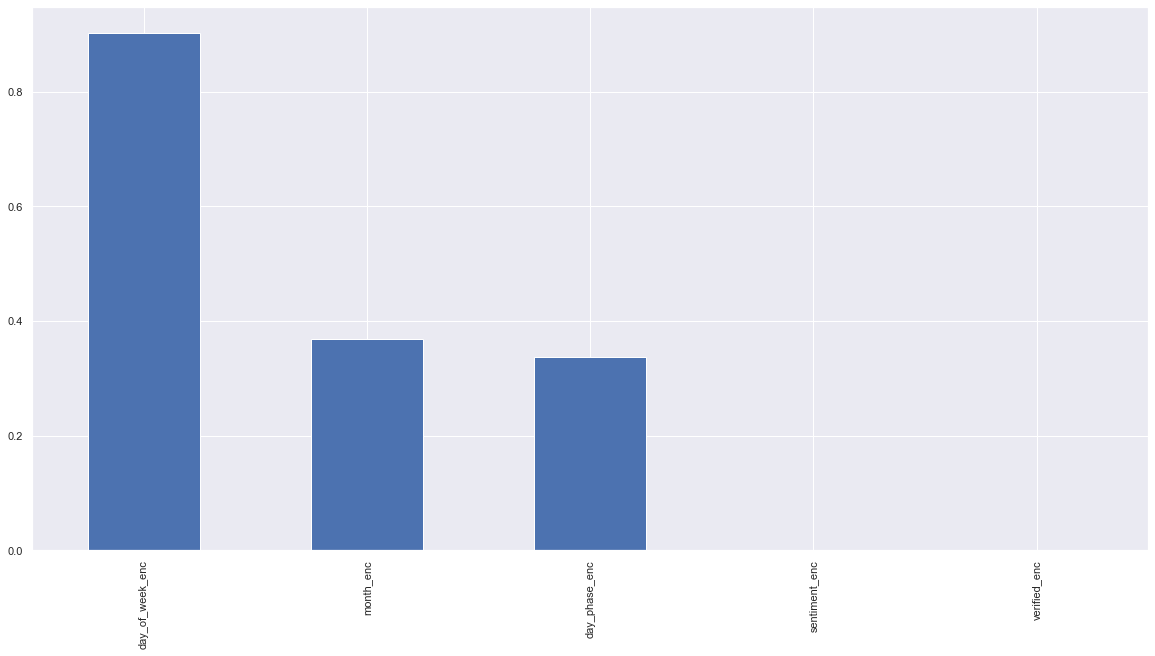

In [273]:
p_values = pd.Series(chi_scores[1], index=cat_vars)
p_values.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(20, 10))
p_values.plot.bar()

In [274]:
chi2_features = SelectKBest(chi2, k=5)
best_features = chi2_features.fit_transform(X_train[cat_vars], y_train)
cols = chi2_features.get_support(indices=True)
cols

array([0, 1, 2, 3, 4])

In [275]:
features_to_keep = X_train[cat_vars].iloc[:, cols]
features_to_keep.columns

Index(['sentiment_enc', 'verified_enc', 'day_of_week_enc', 'day_phase_enc',
       'month_enc'],
      dtype='object')

In [276]:
features_to_keep

,sentiment_enc,verified_enc,day_of_week_enc,day_phase_enc,month_enc
0,2,0,6,1,4
1044,1,0,6,1,4
1042,1,0,6,1,4
1041,2,0,6,1,4
1040,1,0,6,1,4
...,...,...,...,...,...
241760,1,0,2,2,0
241642,2,0,2,2,0
241761,1,0,2,2,0
241643,0,0,2,2,0


In [277]:
cat_feat_to_keep = pd.DataFrame(index=cat_vars)
cat_feat_to_keep

""
sentiment_enc
verified_enc
day_of_week_enc
day_phase_enc
month_enc


In [278]:
cat_feat_to_keep['Chi square'] = 'Discard'
cat_feat_to_keep.loc[['sentiment_enc', 'verified_enc', 'day_phase_enc', 'month_enc'],'Chi square']='Keep'

### Ridge regression

In [279]:
ridge = RidgeCV()
ridge.fit(X_train_num_scaled, y_train)
print("Best score using built-in RidgeCV: %f" % ridge.score(X_train_num_scaled, y_train))

Best score using built-in RidgeCV: 0.014879


/Users/migueloliveira/PycharmProjects/SocialInsight/venv/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning:

divide by zero encountered in reciprocal



In [280]:
coef_ridge = pd.Series(ridge.coef_, index=X_train_num_scaled.columns)
coef_ridge.sort_values().head()

retweet_count   -0.029492
tweet_count     -0.005788
seniority        0.005616
reach            0.013158
followers        0.013158
dtype: float64

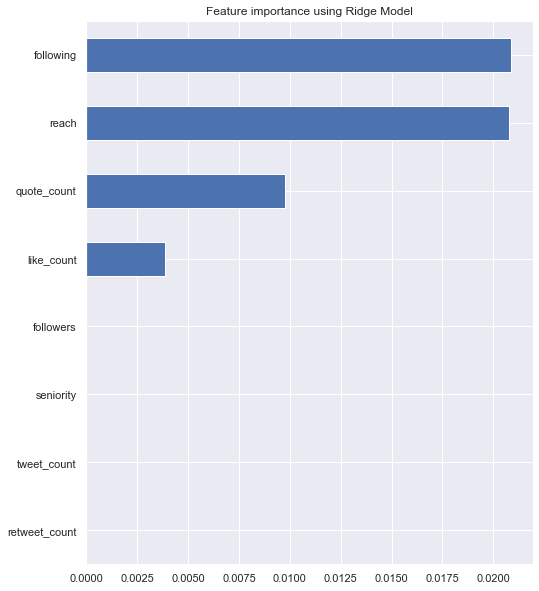

In [281]:
plot_importance(coef, 'Ridge')

In [282]:
num_feat_to_keep['Ridge Regression'] = 'Discard'

for var in abs(coef_ridge).nlargest(5).index:
  num_feat_to_keep.loc[var,'Ridge Regression'] = 'Keep'

### ANOVA

In [283]:
# Select features with best ANOVA F-Values
fvalue_selector = SelectKBest(f_classif, k='all')
X_kbest = fvalue_selector.fit_transform(X_train_num_scaled, y_train)
print('Original number of features:', X_train_num_scaled.shape[1])
print('Reduced number of features:', X_kbest.shape[1])

Original number of features: 8
Reduced number of features: 8


In [284]:
cols = fvalue_selector.get_support(indices=True)
features_to_keep = X_train_num_scaled.iloc[:, cols]
features_to_keep.columns

Index(['like_count', 'retweet_count', 'quote_count', 'reach', 'followers',
       'following', 'tweet_count', 'seniority'],
      dtype='object')

<AxesSubplot:>

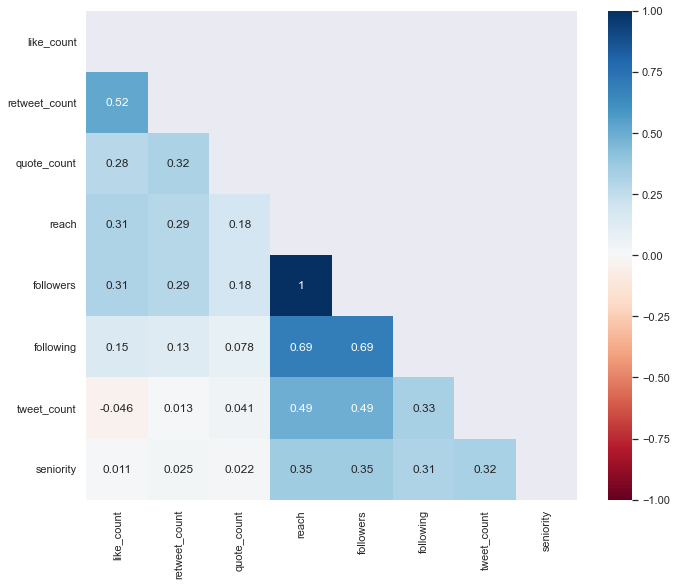

In [285]:
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(X_train_num_scaled.corr(method="spearman"), dtype=bool))
sns.heatmap(X_train_num_scaled.corr(method="spearman"), annot=True, mask=mask, vmin=-1, vmax=1, cmap='RdBu')

In [286]:
num_feat_to_keep['ANOVA'] = 'Discard'

for var in features_to_keep.columns:
    num_feat_to_keep.loc[var, 'ANOVA'] = 'Keep'

### Tree-Based Classifiers

[0.09575064 0.61109734 0.15613223 0.04896538 0.0455859  0.01775753
 0.01570817 0.00900281]


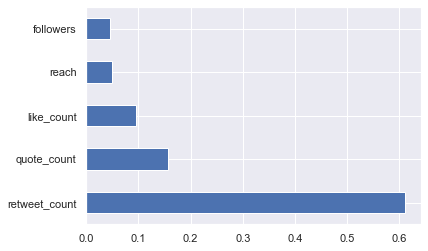

In [287]:
#TREE BASED CLASSIFIERS
model = ExtraTreesClassifier()
model.fit(X_train_num_scaled, y_train)
print(model.feature_importances_)  #use inbuilt class feature_importances of tree based classifiers

feat_importances = pd.Series(model.feature_importances_, index=X_train_num_scaled.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

In [288]:
feat_importances.nlargest(5).index

Index(['retweet_count', 'quote_count', 'like_count', 'reach', 'followers'], dtype='object')

In [289]:
num_feat_to_keep['Tree Based Classifiers'] = 'Discard'

for var in feat_importances.nlargest(5).index:
    num_feat_to_keep.loc[var, 'Tree Based Classifiers'] = 'Keep'

### ENTROPY / GINI IMPORTANCE

In [290]:
#ENTROPY / GINI IMPORTANCE
gini_importance = DecisionTreeClassifier().fit(X_train_num_scaled, y_train).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy').fit(X_train_num_scaled, y_train).feature_importances_

<AxesSubplot:xlabel='Value', ylabel='Col'>

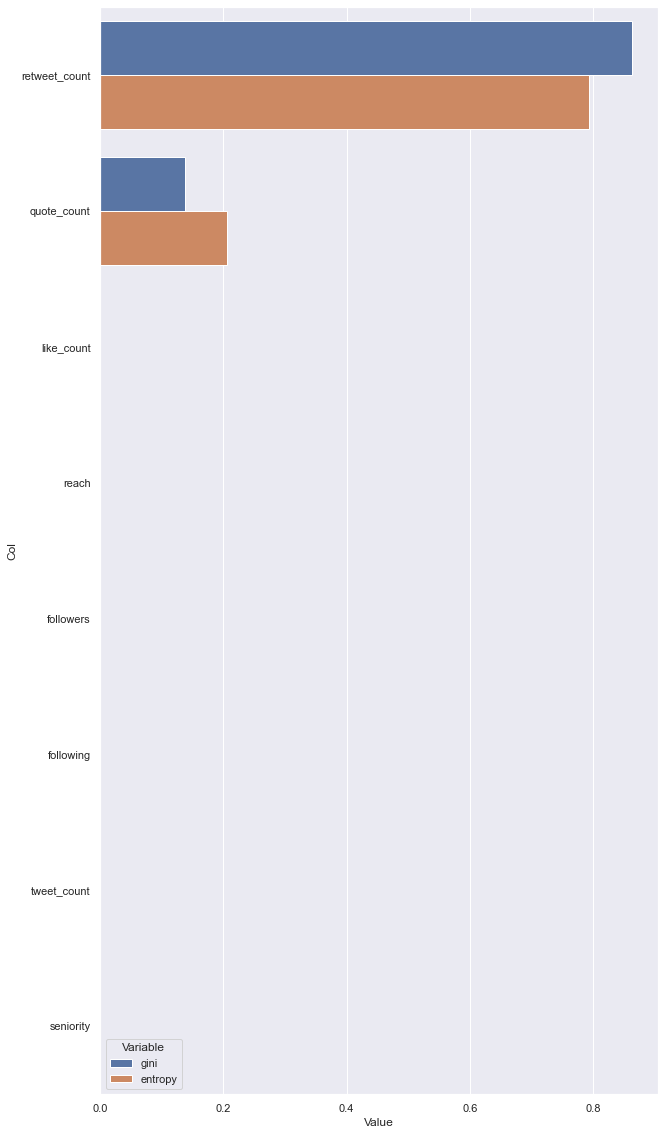

In [291]:
zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns=['gini', 'entropy'])
zippy['col'] = X_train_num_scaled.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending=False, inplace=True)

plt.figure(figsize=(10, 20))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

In [292]:
zippy = zippy.set_index('col')
num_feat_to_keep['Gini Importance'] = 'Discard'

for var in zippy['gini'].nlargest(5).index:
    num_feat_to_keep.loc[var, 'Gini Importance'] = 'Keep'

### Forward Selection

In [293]:
sys.modules['sklearn.externals.joblib'] = joblib
sfs = Sfs(LogisticRegression(),
          k_features=5,
          forward=True,
          floating=False,
          scoring='r2',
          cv=5)
sfs.fit(X_train_num_scaled, y_train)
sfs.k_feature_names_

('like_count', 'retweet_count', 'quote_count', 'reach', 'following')

In [294]:
num_feat_to_keep['Sequential Feature Selection'] = 'Discard'

for var in sfs.k_feature_names_:
    num_feat_to_keep.loc[var, 'Sequential Feature Selection'] = 'Keep'

### Final Selected Variables

In [295]:
num_feat_to_keep['Discard Nr'] = num_feat_to_keep.apply(lambda x: x.str.findall('Discard').str.len()).sum(
    axis=1).astype(int)
num_feat_to_keep

,RFE,Ridge Regression,ANOVA,Tree Based Classifiers,Gini Importance,Sequential Feature Selection,Discard Nr
like_count,Keep,Keep,Keep,Keep,Keep,Keep,0
retweet_count,Keep,Keep,Keep,Keep,Keep,Keep,0
quote_count,Keep,Keep,Keep,Keep,Keep,Keep,0
reach,Keep,Keep,Keep,Keep,Keep,Keep,0
followers,Keep,Discard,Keep,Keep,Keep,Discard,2
following,Discard,Keep,Keep,Discard,Discard,Keep,3
tweet_count,Discard,Discard,Keep,Discard,Discard,Discard,5
seniority,Discard,Discard,Keep,Discard,Discard,Discard,5


In [296]:
cat_feat_to_keep

,Chi square
sentiment_enc,Keep
verified_enc,Keep
day_of_week_enc,Discard
day_phase_enc,Keep
month_enc,Keep


In [297]:
variables_to_keep = ['like_count', 'reach', 'followers', 'following', 'month_enc', 'verified_enc', 'day_phase_enc']

In [298]:
X_train_scaled = X_train_scaled[variables_to_keep]
X_val_scaled = X_val_scaled[variables_to_keep]
df_2020['popularity'].value_counts(normalize=True)

0    0.807707
1    0.192293
Name: popularity, dtype: float64

## Balacing the dataset

#### Random Under Sampling method

In [299]:
# summarize class distribution
print("Before under sampling: ", Counter(y_train))
# define undersampling strategy
under_sample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_train_under, y_train_under = under_sample.fit_resample(X_train_scaled, y_train)
# summarize class distribution
print("After under sampling: ", Counter(y_train_under))

Before under sampling:  Counter({0: 127485, 1: 31160})
After under sampling:  Counter({0: 31160, 1: 31160})


#### SMOTE method

In [300]:
# summarize class distribution
print("Before over sampling: ", Counter(y_train))
over_sample = SMOTE(random_state=seed)
X_train_over, y_train_over = over_sample.fit_resample(X_train_scaled, y_train)
# summarize class distribution
print("After over sampling: ", Counter(y_train_over))

Before over sampling:  Counter({0: 127485, 1: 31160})
After over sampling:  Counter({0: 127485, 1: 127485})


## Models

### Defining the algorithms

In [301]:
models = [('LR', LogisticRegression(solver='lbfgs')), ('LDA', LinearDiscriminantAnalysis()),
          ('KNN', KNeighborsClassifier()), ('CART', DecisionTreeClassifier()), ('NB', GaussianNB())]
          #('SVM', SVC(gamma='scale'))]

In [302]:
def algorithm_comparison(title):
    fig = plt.figure()
    fig.suptitle(title)
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.figure(figsize=(16, 9))
    plt.show()

#### Algorithm benchmark with Under Sampling

In [303]:
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=num_folds)
	cv_results = cross_val_score(model, X_train_under, y_train_under, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.640164 (0.239869)
LDA: 0.069143 (0.083742)
KNN: 0.555472 (0.176289)
CART: 0.568421 (0.156546)
NB: 0.617747 (0.359886)


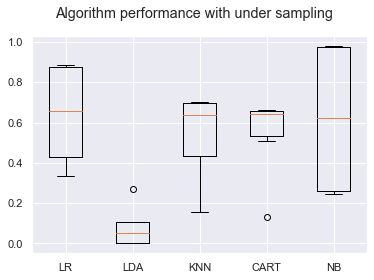

<Figure size 1152x648 with 0 Axes>

In [304]:
algorithm_comparison('Algorithm performance with under sampling')

#### Algorithm benchmark with Over Sampling

In [305]:
results = []
names = []
for name, model in models:
	kfold = KFold(n_splits=num_folds)
	cv_results = cross_val_score(model, X_train_over, y_train_over, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.695050 (0.150379)
LDA: 0.200537 (0.078225)
KNN: 0.763149 (0.087710)
CART: 0.807405 (0.073067)
NB: 0.615833 (0.273274)


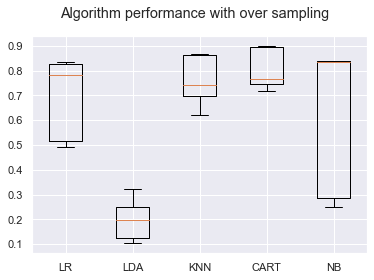

<Figure size 1152x648 with 0 Axes>

In [306]:
algorithm_comparison('Algorithm performance with over sampling')

### Ensemble methods

#### Algorithm benchmark with Under Sampling

In [307]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

ensembles = [('AB', AdaBoostClassifier()), ('GBM', GradientBoostingClassifier()),
             ('RFC', RandomForestClassifier(n_estimators=100)), ('ET', ExtraTreesClassifier())]
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train_under, y_train_under, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.599246 (0.179873)
GBM: 0.601203 (0.180250)
RFC: 0.601556 (0.174063)
ET: 0.564265 (0.168954)


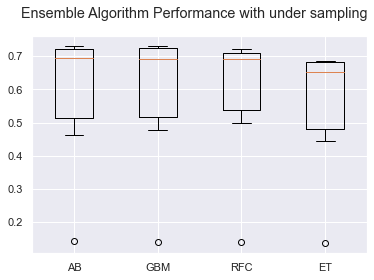

<Figure size 1152x648 with 0 Axes>

In [308]:
algorithm_comparison('Ensemble Algorithm Performance with under sampling')

#### Algorithm benchmark with Over Sampling

In [309]:
ensembles = [('AB', AdaBoostClassifier()), ('GBM', GradientBoostingClassifier()),
             ('RFC', RandomForestClassifier(n_estimators=100)), ('ET', ExtraTreesClassifier())]
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train_over, y_train_over, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.768310 (0.051799)
GBM: 0.774707 (0.040837)
RFC: 0.818908 (0.055386)
ET: 0.767537 (0.060231)


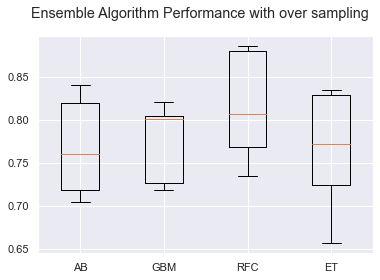

<Figure size 1152x648 with 0 Axes>

In [310]:
algorithm_comparison('Ensemble Algorithm Performance with over sampling')

#### Tuning the best ensemble model (RFC)

In [311]:
# param_grid = dict(n_estimators=numpy.array([50, 100, 150, 200, 250, 300, 350, 400]))
#param_grid = dict(n_estimators=numpy.array([50, 200, 300, 400]))
#model = RandomForestClassifier(random_state=seed)
#kfold = KFold(n_splits=num_folds)
#grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
#grid_result = grid.fit(X_train_over, y_train_over)

#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.819108 using {'n_estimators': 200}
0.818069 (0.053417) with: {'n_estimators': 50}
0.819108 (0.054975) with: {'n_estimators': 200}
0.819038 (0.055245) with: {'n_estimators': 300}
0.818994 (0.055129) with: {'n_estimators': 400}


#### Tuning Gradient Boosting Classifier

In [312]:
param_grid = dict(n_estimators=numpy.array([20, 30, 40, 50, 60, 70, 80]))
model = GradientBoostingClassifier(random_state=seed, learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.856302 using {'n_estimators': 60}
0.855375 (0.002931) with: {'n_estimators': 20}
0.856176 (0.003526) with: {'n_estimators': 30}
0.856289 (0.003593) with: {'n_estimators': 40}
0.856289 (0.003466) with: {'n_estimators': 50}
0.856302 (0.003489) with: {'n_estimators': 60}
0.856277 (0.003583) with: {'n_estimators': 70}
0.856138 (0.003664) with: {'n_estimators': 80}


In [313]:
param_grid2 = {'max_depth':[9], 'min_samples_split':range(1000,1601,200)}
model = GradientBoostingClassifier(random_state=seed, learning_rate=0.1, n_estimators=40, max_features='sqrt',subsample=0.8)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid2, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

#0.857884 : acc
# 0.850

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.855229 using {'max_depth': 9, 'min_samples_split': 1400}
0.855189 (0.003507) with: {'max_depth': 9, 'min_samples_split': 1000}
0.854984 (0.003505) with: {'max_depth': 9, 'min_samples_split': 1200}
0.855229 (0.003531) with: {'max_depth': 9, 'min_samples_split': 1400}
0.855074 (0.003593) with: {'max_depth': 9, 'min_samples_split': 1600}


In [314]:
param_grid3 = {'min_samples_split':range(1000,1600,200), 'min_samples_leaf':range(30,71,10)}
model = GradientBoostingClassifier(random_state=seed, learning_rate=0.1, n_estimators=40, max_depth=9, max_features='sqrt',subsample=0.8)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid3, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.855221 using {'min_samples_leaf': 30, 'min_samples_split': 1000}
0.855221 (0.003262) with: {'min_samples_leaf': 30, 'min_samples_split': 1000}
0.855139 (0.003382) with: {'min_samples_leaf': 30, 'min_samples_split': 1200}
0.855081 (0.003515) with: {'min_samples_leaf': 30, 'min_samples_split': 1400}
0.854969 (0.003317) with: {'min_samples_leaf': 40, 'min_samples_split': 1000}
0.855055 (0.003538) with: {'min_samples_leaf': 40, 'min_samples_split': 1200}
0.855079 (0.003357) with: {'min_samples_leaf': 40, 'min_samples_split': 1400}
0.855107 (0.003366) with: {'min_samples_leaf': 50, 'min_samples_split': 1000}
0.855216 (0.003551) with: {'min_samples_leaf': 50, 'min_samples_split': 1200}
0.855043 (0.003305) with: {'min_samples_leaf': 50, 'min_samples_split': 1400}
0.855159 (0.003575) with: {'min_samples_leaf': 60, 'min_samples_split': 1000}
0.855120 (0.003623) with: {'min_samples_leaf': 60, 'min_samples_split': 1200}
0.855000 (0.003222) with: {'min_samples_leaf': 60, 'min_samples_split

In [315]:
param_grid4 = {'max_features':range(7,20,2)}
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40, max_depth=9, min_samples_split=1200, min_samples_leaf=40, subsample=0.8, random_state=10)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid4, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/migueloliveira/PycharmProjects/SocialInsight/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


60 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/migueloliveira/PycharmProjects/SocialInsight/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/migueloliveira/PycharmProjects/SocialInsight/venv/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 586, in fit
    n_stages = self._fit_stages(
  File "/Users/migueloliveira/PycharmProjects/SocialInsi

Best: 0.855465 using {'max_features': 7}
0.855465 (0.003538) with: {'max_features': 7}
nan (nan) with: {'max_features': 9}
nan (nan) with: {'max_features': 11}
nan (nan) with: {'max_features': 13}
nan (nan) with: {'max_features': 15}
nan (nan) with: {'max_features': 17}
nan (nan) with: {'max_features': 19}


In [316]:
param_grid5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=40, max_depth=9, min_samples_split=1200, min_samples_leaf=40, subsample=0.8, max_features=7, random_state=seed)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid5, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.855510 using {'subsample': 0.85}
0.855360 (0.003585) with: {'subsample': 0.6}
0.855288 (0.003580) with: {'subsample': 0.7}
0.855355 (0.003620) with: {'subsample': 0.75}
0.855368 (0.003481) with: {'subsample': 0.8}
0.855510 (0.003539) with: {'subsample': 0.85}
0.855426 (0.003461) with: {'subsample': 0.9}


#### The final values were:

min_samples_split: 1200
min_samples_leaf: 40
max_depth: 9
max_features: 7
subsample: 0.85

New test with half the learning rate and double the nº of trees (estimators)

In [317]:
model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=80, max_depth=9, min_samples_split=1200, min_samples_leaf=40, subsample=0.85, max_features=7, random_state=seed)

model.fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
print(accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))

0.38809151396779346
[[ 83152 216493]
 [ 10019  60509]]
              precision    recall  f1-score   support

           0       0.89      0.28      0.42    299645
           1       0.22      0.86      0.35     70528

    accuracy                           0.39    370173
   macro avg       0.56      0.57      0.39    370173
weighted avg       0.76      0.39      0.41    370173



In [318]:
model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=400, max_depth=9, min_samples_split=1200, min_samples_leaf=40, subsample=0.85, max_features=7, random_state=seed)

model.fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
print(accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))

0.3602234630834772
[[ 72748 226897]
 [  9931  60597]]
              precision    recall  f1-score   support

           0       0.88      0.24      0.38    299645
           1       0.21      0.86      0.34     70528

    accuracy                           0.36    370173
   macro avg       0.55      0.55      0.36    370173
weighted avg       0.75      0.36      0.37    370173



In [319]:
model = GradientBoostingClassifier(learning_rate=0.005, n_estimators=800, max_depth=9, min_samples_split=1200, min_samples_leaf=40, subsample=0.85, max_features=7, random_state=seed)

model.fit(X_train_scaled, y_train)
predictions = model.predict(X_val_scaled)
print(accuracy_score(y_validation, predictions))
print(confusion_matrix(y_validation, predictions))
print(classification_report(y_validation, predictions))

0.36277362206319747
[[ 73017 226628]
 [  9256  61272]]
              precision    recall  f1-score   support

           0       0.89      0.24      0.38    299645
           1       0.21      0.87      0.34     70528

    accuracy                           0.36    370173
   macro avg       0.55      0.56      0.36    370173
weighted avg       0.76      0.36      0.37    370173



In [320]:
def run_tuned_random_forest(x_train, x_test, y_train, y_test):
    model = RandomForestClassifier(random_state=seed, n_estimators=100)
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    print(accuracy_score(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))
    joblib.dump(model, '../../data/models/popularity.joblib')

In [321]:
run_tuned_random_forest(X_train_over, X_val_scaled, y_train_over, y_validation)

0.19137268250250558
[[   402 299243]
 [    89  70439]]
              precision    recall  f1-score   support

           0       0.82      0.00      0.00    299645
           1       0.19      1.00      0.32     70528

    accuracy                           0.19    370173
   macro avg       0.50      0.50      0.16    370173
weighted avg       0.70      0.19      0.06    370173



## Testing the created model to predict 2021 tweets popularity

In [322]:
test_2021 = df_2021[variables_to_keep]
target = df_2021['popularity']

In [323]:
popularity_model = joblib.load('../../data/models/popularity.joblib')
predictions = popularity_model.predict(test_2021)
print(accuracy_score(target, predictions))
print(confusion_matrix(target, predictions))
print(classification_report(target, predictions))

0.19235027794419882
[[     0 425990]
 [     0 101454]]


/Users/migueloliveira/PycharmProjects/SocialInsight/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/migueloliveira/PycharmProjects/SocialInsight/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.00      0.00      0.00    425990
           1       0.19      1.00      0.32    101454

    accuracy                           0.19    527444
   macro avg       0.10      0.50      0.16    527444
weighted avg       0.04      0.19      0.06    527444



/Users/migueloliveira/PycharmProjects/SocialInsight/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [324]:
X_train_over['']

KeyError: ''